In [2663]:
# Set up

import torch
from torch import zeros, ones

import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import pandas as pd
import sys
import copy

file_path = '/home/student/meta_pjt/3times_participants_data.csv'
fd = pd.read_csv(file_path, usecols=list(range(12)), skiprows=0)
raw_data = fd.values
torch_data = torch.tensor(raw_data, dtype=torch.float32)

nc = 3
nb = 9
nt = 120
ni = 2 
nw = 2

sandy= "#D2B48C"
sea = "#1f77b4"
light_blue = "#87CEEB"

import os
import sys

# Set the directory from which the simmulator model and agent model will be imported
os.getcwd()

%cd /home/student/meta_pjt/
sys.path.append('/home/student/meta_pjt/')

# Create subdirectory if it doesn't exist
output_dir = 'plots'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

/home/student/meta_pjt


In [2664]:
expn = 1000 #experiment (actually simulation) number

In [2665]:
# Instrumental functions

# Translate condition number in raw data into 0 (1 rule), 1 (2 rules), 2 (3 rules) ...(number of conditions of interest)
def get_condition(dat):
         
    if dat == 1 or dat == 2 or dat ==3:
        condition = 0
    elif dat == 4 or dat == 5 or dat ==6:
        condition = 1
    elif dat == 7:
        condition = 2
        
    return condition

# Translate question number into 0 (feature trial), 1 (category trial)
def get_question(dat):
         
    if dat == 1 or dat == 2 or dat ==3:
        question = 0
    elif dat == 4 or dat == 5 or dat ==6:
        question = 1
            
    return question

# Plot the mean and std of belief (along all the trials)
def plot_belief(belief_list, sam, dd, label=None):
    tot = len(belief_list)
    mpF = zeros(tot)
    spF = zeros(tot)
    for i, belief in enumerate(belief_list):
        mpF[i] = torch.sum(belief * sam) * dd
        spF[i] = torch.sum(belief * (sam - mpF[i]) ** 2) * dd
    plt.plot(torch.arange(tot), mpF, label = label)
    plt.fill_between(torch.arange(tot), mpF - spF, mpF + spF, alpha = 0.2)
    plt.legend()

    plt.xlabel('trial number')

# Calculate mean of belief distribution (not mean of belief array itself)
def mean_belief(belief_list, sam, dd):
    tot = len(belief_list)
    mpF = zeros(tot)
    for i, belief in enumerate(belief_list):
        mpF[i] = torch.sum(belief * sam) * dd
    return mpF

In [2666]:
# Import or renew simulator model and agent model

if 'Meta_control_simulate_behavior' in sys.modules:
    del sys.modules['Meta_control_simulate_behavior']
    print('凌波微步')

if 'Meta_control_agent' in sys.modules:
    del sys.modules['Meta_control_agent']
    print('羅襪生塵')

from Meta_control_simulate_behavior import Simulator_Behavior
from Meta_control_agent import MetaAgent

凌波微步
羅襪生塵


In [2668]:
# Settle behaviour data to be input into the simulator

ag = 2
nb = 9
ni = 2
agent_data = torch_data[torch.where(torch_data[:, 0] == ag)[0][:1080], :]

conditions = zeros(nb)
questions = zeros(nb, nt)
reaction_times = zeros(nb, nt)
errors = zeros(nb, nt)

count = 0
count_f = 0
count_c = 0
mean_f_error = 0
mean_c_error = 0

f_e = []
c_e = []

for b in torch.arange(nb):
    conditions[b] =  get_condition(agent_data[count, 2])

    for t in torch.arange(nt):
        questions[b, t] = get_question(agent_data[count, 3])

        if questions[b, t] == 1:
            reaction_times[b, t] = agent_data[count, 11] 
            errors[b, t] = agent_data[count, 10]
            if ~torch.isnan(errors[b, t]):
                mean_c_error += errors[b, t]
                c_e.append(errors[b, t])
                count_c += 1
        elif questions[b, t] == 0:
            errors[b, t] = agent_data[count, 7] * torch.pi / 180
            if ~torch.isnan(errors[b, t]):
                mean_f_error += errors[b, t]
                f_e.append(errors[b, t])
                count_f += 1
        count += 1

mean_f_error = mean_f_error / count_f
mean_c_error = mean_c_error / count_c

f_error = torch.stack(f_e)
c_error = torch.stack(c_e)

std_f_error = torch.std(f_error)
std_c_error = torch.std(c_error)

data = {}
data['conditions'] = conditions #(b)
data['questions'] = questions#(b, t)
data['reaction_times'] = reaction_times #(b, t)
data['errors'] = errors
data['mean_f_error'] = mean_f_error
data['mean_c_error'] = mean_c_error
data['std_f_error'] = std_f_error
data['std_c_error'] = std_c_error


In [2669]:
# Set possible fit parameters to be input into the agent

fit = {}
fit = {
    #'mlgd0': torch.log(torch.tensor([[[1.1, 0.9], [1.4, 0.8]],[[1.1, 0.9], [1.4, 0.9]], [[1.1, 0.9], [1.4, 1.0]]])), # Shape (nc, ni, nw)
    #'mlgd0': torch.log(torch.tensor([[[1.4, 0.8], [1.6, 0.6]],[[1.4, 0.8], [1.6, 0.65]], [[1.4, 0.8], [1.6, 0.7]]])), # Shape (nc, ni, nw)
    'mlgd0': torch.log(torch.tensor([[[1.2, 0.8], [1.2, 0.8]],[[1.2, 0.8], [1.2, 0.8]], [[1.2, 0.8], [1.2, 0.8]]])), # Shape (nc, ni, nw)
    'sigmad0': torch.tensor([[[0.5, 0.5], [0.5, 0.5]],[[0.5, 0.5], [0.5, 0.5]], [[0.5, 0.5], [0.5, 0.5]]]), # Shape (nc, ni, nw)
    'sigma': torch.tensor(0.3),  # d likelihood std
    'gamma': torch.tensor(5.970671653747559),#1.),#, requires_grad=True),  
    'beta': torch.tensor(7.924981117248535),#2.),#, requires_grad=True),
    'lgdm_ff': torch.tensor(0.6),#torch.log(torch.tensor(1.4)),#, requires_grad=True)),
    'ds_ff': torch.tensor(0.05), 
    'lgdm_cf': torch.tensor([0.6, 0.6, 0.6]),#torch.log(torch.tensor([1.6, 1.6, 1.6])),#, requires_grad=True)), #for different condition
    'ds_cf': torch.tensor([0.05, 0.05, 0.05]),
    'kappa': torch.tensor(10), #elikelihood acuracy
    'me0': torch.tensor([[0, 0], [0, 0], [0, 0]]),#注意i = 0时的mu其实并非真的平均值， 因为取了half
    'ke0': torch.tensor([[65, 65], [70, 70], [73, 73]]),
    'eF_cri': mean_f_error,
    'eC_cri': mean_c_error
}

#Set an agent with fit parameters
agent = MetaAgent(fit=fit, conditions=nc, blocks=nb, trials=nt, e_con=True) 

In [2670]:
# reset fit parameter to values from trained parameter list

for param_name, param in r_list_a2_ll_31.items():
    setattr(agent, param_name, param[-1])

In [2672]:
# Check your present fit parameter
agent.beta, agent.gamma#, agent.lgdm_ff, agent.lgdm_cf, torch.exp(agent.lgdm_ff), torch.exp(agent.lgdm_cf)

(tensor(11.5608), tensor(3.3537))

In [2673]:
ag

2

In [2674]:
#Decide to save figure or not, 0 for no saving, 1 for saving
save_fig = 0

In [2675]:
expn #experiment number

1000

In [2678]:
# Run simulations until you get a simulation with its ED below ED_thr (that you set here)

diff = 1
ED_thr = -0.08
while diff >= ED_thr:
    agent.initiate_prior_plan_strategy()
    if agent.d_con:
        agent.initiate_md_distribution()
    if agent.e_con:
        agent.initiate_me_distribution()

    simulator = Simulator_Behavior(data=data, agents=agent, conditions=3, blocks=9, trials=120)
    simulator.simulate_experiment()

    diff = simulator.error_diff
    print(simulator.error_diff)

expn += 1

tensor(0.0794)
tensor(-0.0800)
tensor(-0.0443)
tensor(-0.0590)
tensor(-0.0387)
tensor(-0.0635)
tensor(0.0855)
tensor(-0.0390)
tensor(-0.0634)
tensor(-0.0855)


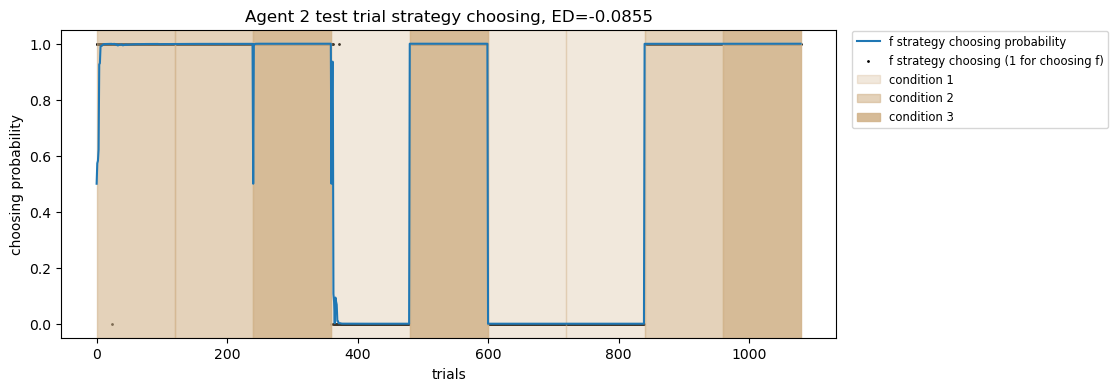

In [2679]:
#Plot strategy choosing probability of a single simulation
def plot_plan(plan_str, strs, ED , ag, f_name = f'default', save_fig = 0):
    p_str = torch.stack(plan_str)
    tot = torch.arange(p_str.size(0))
    plt.figure(figsize=(10,4))
    plt.plot(tot, p_str[:, 0], color=sea, label='f strategy choosing probability')

    #plt.plot(tot, p_str[:, 1], label='c strategy choosing')
    #for b, k in enumerate(range(0, p_str.size(0), nt)):

    strategies = torch.stack(strs)
    tot1 = torch.arange(strategies.size(0))
    plt.scatter(tot1, 1-strategies, color='black', s=1, label='f strategy choosing (1 for choosing f)')

    c0 = torch.where(conditions==0)[0] * 120
    c1 = torch.where(conditions==1)[0] * 120
    c2 = torch.where(conditions==2)[0] * 120

    # Initialize flags to ensure labels are only added once
    label_c0_added = False
    label_c1_added = False
    label_c2_added = False

    color = sandy
    for loc in c0:
        if not label_c0_added:
            plt.axvspan(xmin=loc, xmax=loc+120, color=color, alpha=0.3, label='condition 1')
            label_c0_added = True
        else:
            plt.axvspan(xmin=loc, xmax=loc+120, color=color, alpha=0.3)

    for loc in c1:
        if not label_c1_added:
            plt.axvspan(xmin=loc, xmax=loc+120, color=color, alpha=0.6, label='condition 2')
            label_c1_added = True
        else:
            plt.axvspan(xmin=loc, xmax=loc+120, color=color, alpha=0.6)

    for loc in c2:
        if not label_c2_added:
            plt.axvspan(xmin=loc, xmax=loc+120, color=color, alpha=0.9, label='condition 3')
            label_c2_added = True
        else:
            plt.axvspan(xmin=loc, xmax=loc+120, color=color, alpha=0.9)

    # Add legend outside the plot
    plt.legend(fontsize='small', loc=(1.02, 0.68))

    plt.title(f'Agent {ag} test trial strategy choosing, ED={ED:.4f}')
    plt.xlabel('trials')
    plt.ylabel('choosing probability')
    if save_fig == 1:
            plt.savefig(os.path.join(output_dir, f_name), dpi=300, bbox_inches='tight')

    # Adjust the layout to make room for the legend
    #plt.tight_layout()
    plt.show()

plot_plan(agent.plan_str, simulator.strs, simulator.error_diff, ag=ag, f_name = f'N{expn}, Agent {ag} ED={simulator.error_diff:.4f} Fitted gent_strategy_choosing.png', save_fig = save_fig)

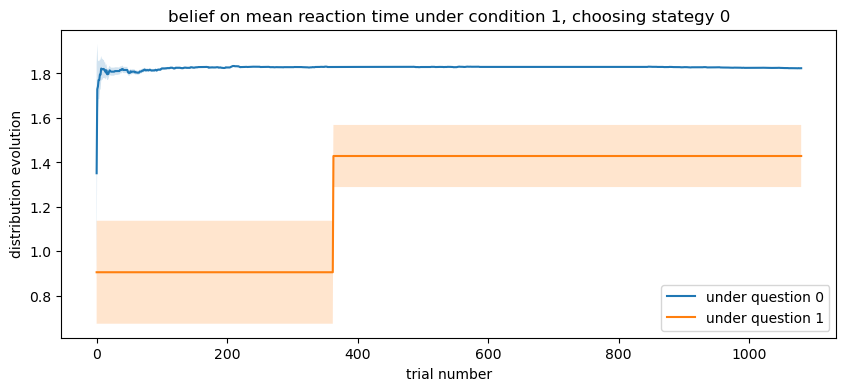

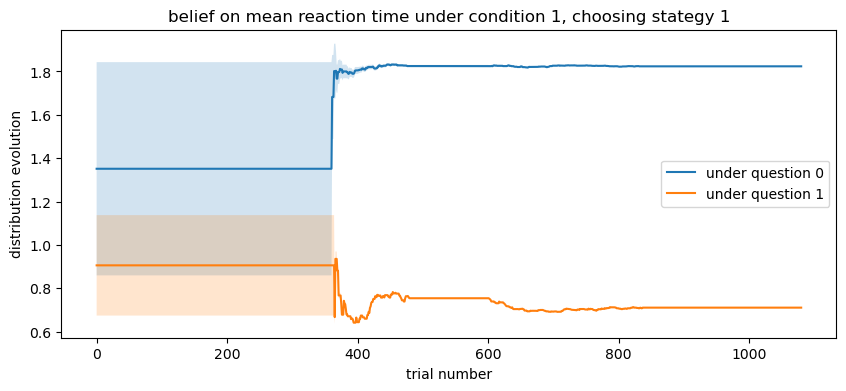

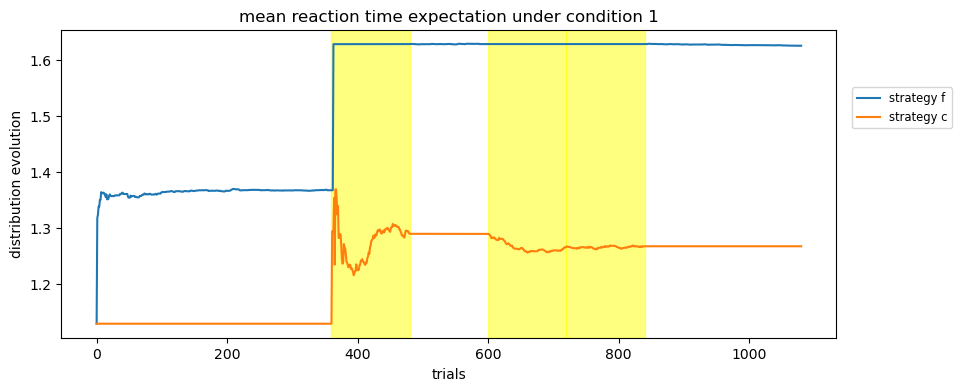

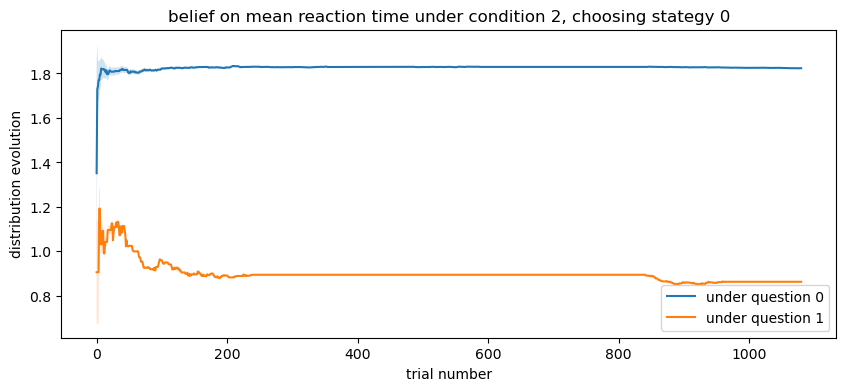

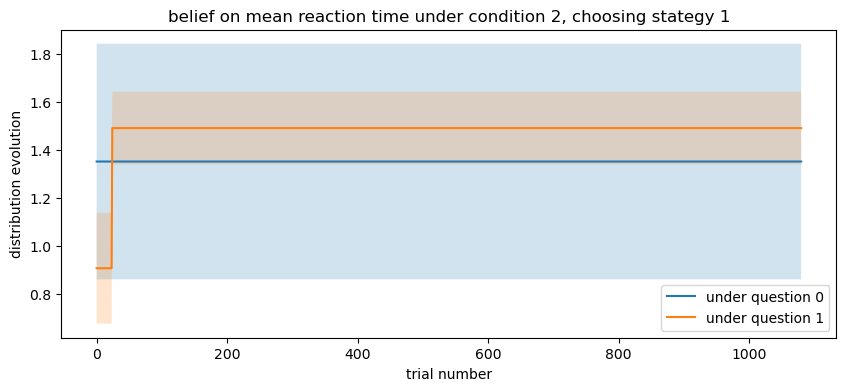

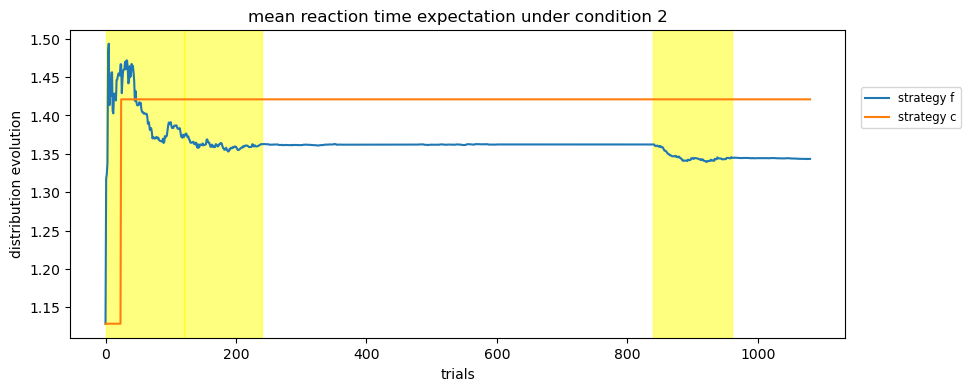

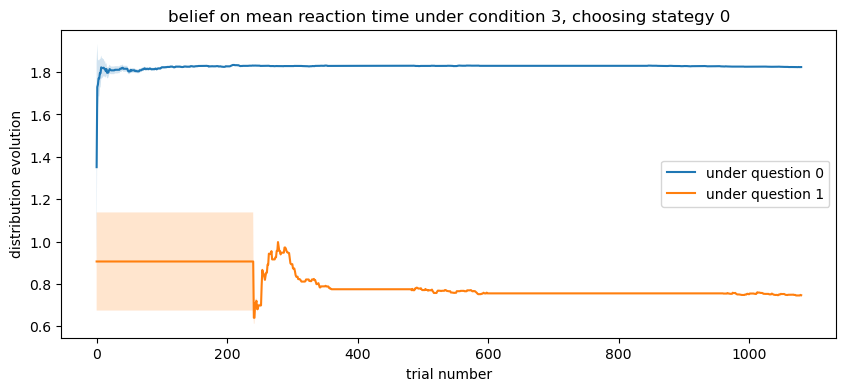

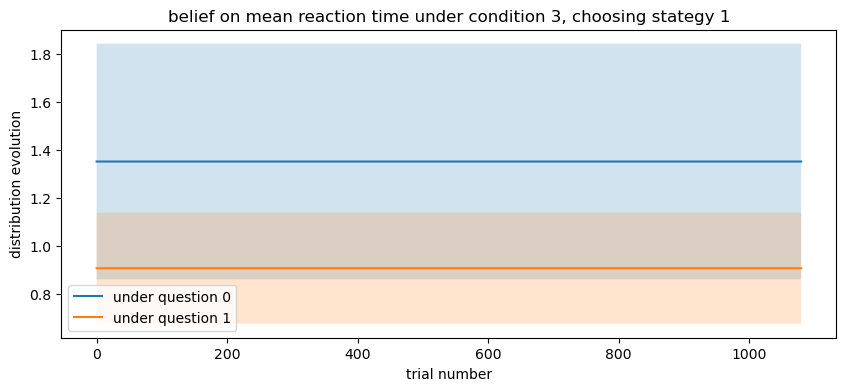

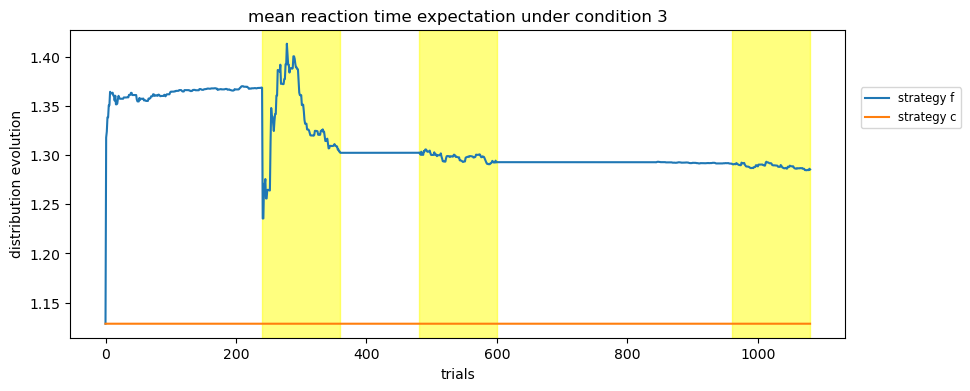

In [2680]:
#reaction time believes evolution (yellow region is where the condition take place)
tot = len(agent.belief_md[(0, 0, 0)])
for c in range(nc):
        md_str = zeros(ni, tot)
        for i in range(ni):
                plt.figure(figsize=(10,4))
                plt.title(f'belief on mean reaction time under condition {c+1}, choosing stategy {i}')
                plt.ylabel('distribution evolution')
                for w in range(nw):
                        plot_belief(agent.belief_md[(c, i, w)], sam=agent.dsam, dd=agent.dt, label=f'under question {w}')
                        md_str[i] += 0.5 * mean_belief(agent.belief_md[(c, i, w)], sam=agent.dsam, dd=agent.dt)
                
                if save_fig == 1:
                        plt.savefig(os.path.join(output_dir, f'N{expn} reaction_time_belief_condition_{c+1}_strategy_{i}.png'), dpi=300, bbox_inches='tight')
                plt.show()

        plt.figure(figsize=(10,4))
        plt.title(f'mean reaction time expectation under condition {c+1}')
        plt.plot(torch.arange(tot), md_str[0], label='strategy f')
        plt.plot(torch.arange(tot), md_str[1], label='strategy c')
        plt.xlabel('trials')
        plt.ylabel('distribution evolution')

        p_str = torch.stack(agent.plan_str)
        #score = torch.stack(agent.score_list) /100
        tot1 = torch.arange(p_str.size(0))
        #tot2 = torch.arange(score.size(0))
        
        #plt.plot(tot1, p_str[:, 0], label='f strategy choosing', color='black')
        #plt.plot(tot2, score[:, 0], label='f strategy score', color='pink')
        #plt.plot(tot2, score[:, 1], label='c strategy score', color='purple')
        #plt.plot(tot, p_str[:, 1], label='c strategy choosing')
        #for b, k in enumerate(range(0, p_str.size(0), nt)):
        c_loc = torch.where(conditions==c)[0] * 120
        
        for loc in c_loc:
                plt.axvspan(xmin=loc, xmax=loc+120, color='yellow', alpha=0.5)

        plt.legend(fontsize='small', loc=(1.02, 0.68))

        if save_fig == 1:
                plt.savefig(os.path.join(output_dir, f'N{expn} mean_reaction_time_estimation_condition_{c+1}.png'), dpi=300, bbox_inches='tight')

        plt.show()


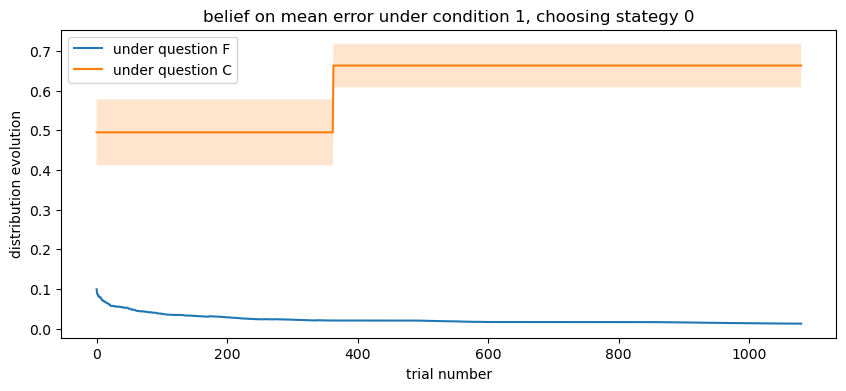

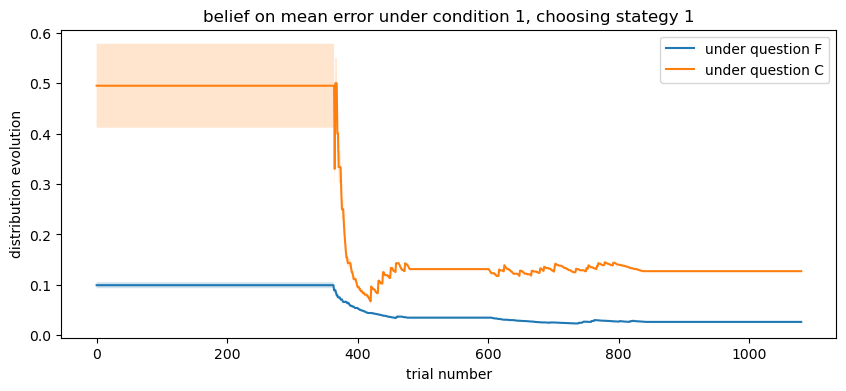

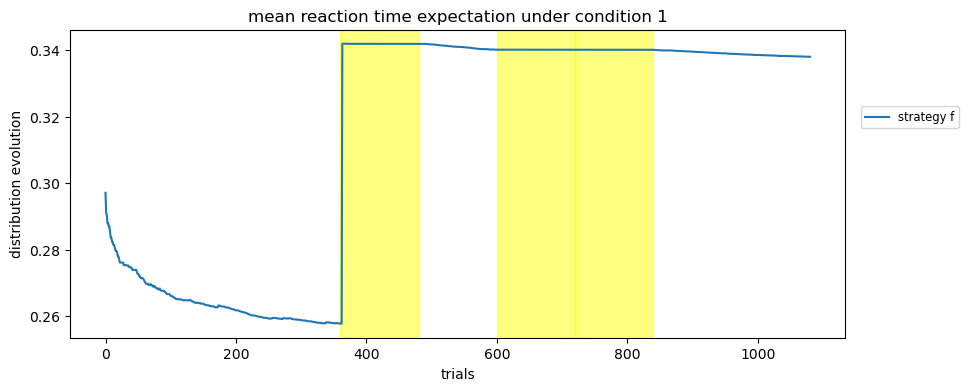

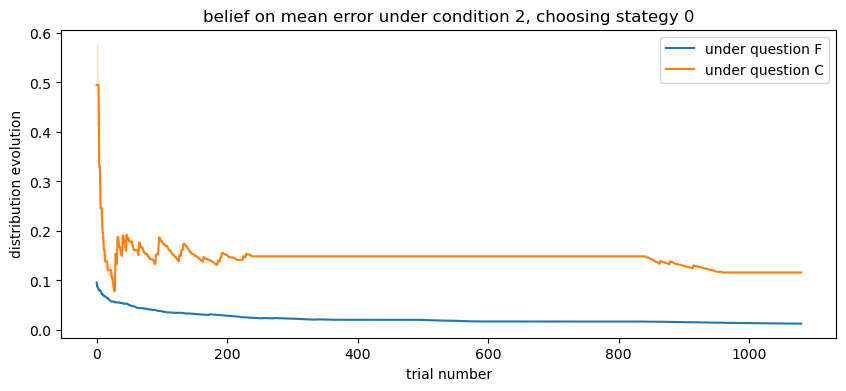

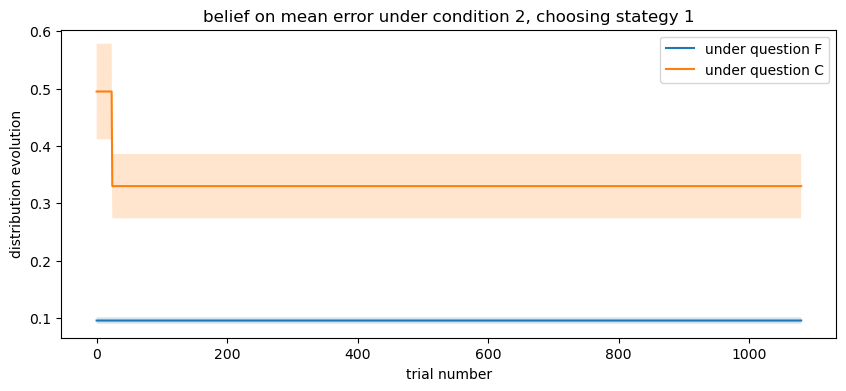

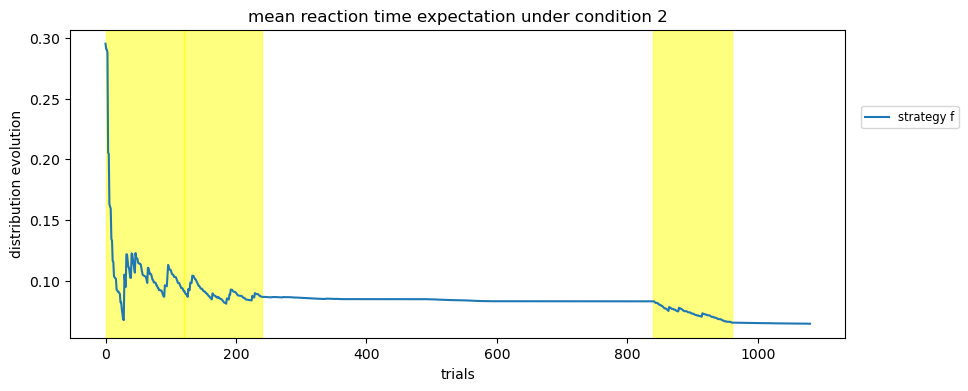

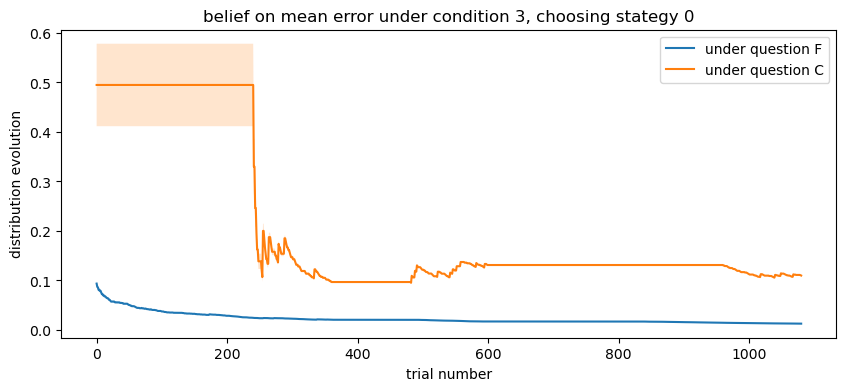

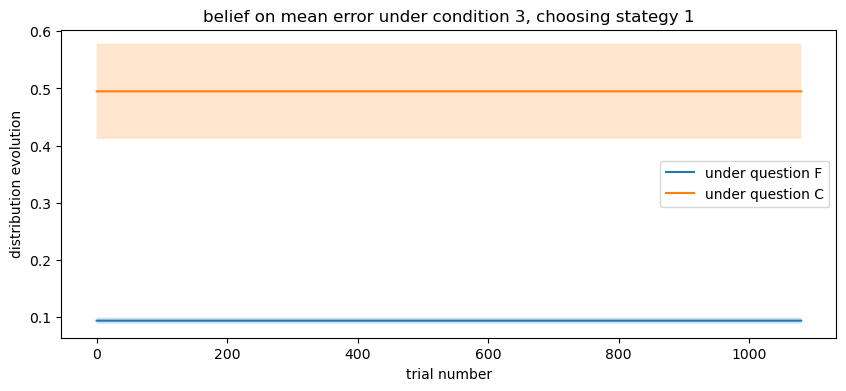

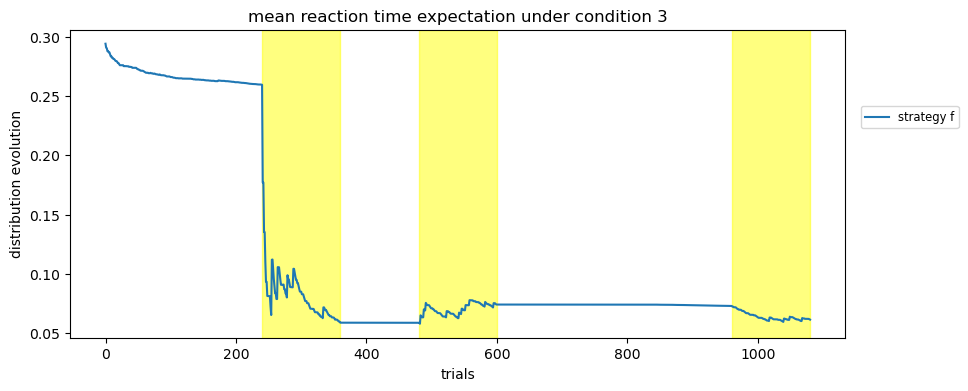

In [2681]:
#error belief evolution (yellow region is where the condition take place)
tot = len(agent.belief_me[(0, 0, 0)])
for c in range(nc):
        me_str = zeros(ni, tot)
        for i in range(ni):
                plt.figure(figsize=(10,4))
                plt.title(f'belief on mean error under condition {c+1}, choosing stategy {i}')
                plt.ylabel('distribution evolution')
                
                plot_belief(agent.belief_me[(c, i, 0)], sam=agent.mesam_F, dd=agent.de_F, label=f'under question F')
                me_str[i] += 0.5 * mean_belief(agent.belief_me[(c, i, 0)], sam=agent.mesam_F, dd=agent.de_F)

                plot_belief(agent.belief_me[(c, i, 1)], sam=agent.mesam_C, dd=agent.de_C, label=f'under question C')
                me_str[i] += 0.5 * mean_belief(agent.belief_me[(c, i, 1)], sam=agent.mesam_C, dd=agent.de_C)

                if save_fig == 1:
                        plt.savefig(os.path.join(output_dir, f'N{expn} error_belief_condition_{c+1}_strategy_{i}_.png'), dpi=300, bbox_inches='tight')
                plt.show()

        plt.figure(figsize=(10,4))
        plt.title(f'mean reaction time expectation under condition {c+1}')
        plt.plot(torch.arange(tot), me_str[0], label='strategy f')
        #plt.plot(torch.arange(tot), me_str[1], label='strategy c')
        plt.xlabel('trials')
        plt.ylabel('distribution evolution')

        p_str = torch.stack(agent.plan_str)
        #score = torch.stack(agent.score_list) /100
        tot1 = torch.arange(p_str.size(0))
        #tot2 = torch.arange(score.size(0))
        
        #plt.plot(tot1, p_str[:, 0], label='f strategy choosing', color='black')
        #plt.plot(tot2, score[:, 0], label='f strategy score', color='pink')
        #plt.plot(tot2, score[:, 1], label='c strategy score', color='purple')
        #plt.plot(tot, p_str[:, 1], label='c strategy choosing')
        #for b, k in enumerate(range(0, p_str.size(0), nt)):
        c_loc = torch.where(conditions==c)[0] * 120
        
        for loc in c_loc:
                plt.axvspan(xmin=loc, xmax=loc+120, color='yellow', alpha=0.5)

        plt.legend(fontsize='small', loc=(1.02, 0.68))
        
        if save_fig == 1:
                plt.savefig(os.path.join(output_dir, f'N{expn} mean_error_estimation_condition_{c+1}.png'), dpi=300, bbox_inches='tight')

        plt.show()


In [2683]:
#Play training trials, get LL, ED, strategy choosing probability lists

agent.update = True # True for Bayesian agent, False for non-updating agent with believes always the same as priors of Bayesian agents
agent.ni = 2 # 1 for non-teade-off Bayesian agent, 2 for trade-off Bayesian agent
nb = 9
ni = 2
expn += 1
n_it = 10 # choose simmulation interation number
Err_diff = zeros(n_it)
Lg_like = zeros(n_it)
p_str_list = []
str_list = []
last_belief_md_list = []
last_belief_me_list = []
ED_thr = -0.05 # the threshold of ED, only those simulations whose ED is below this will be saved into list

for kk in range(n_it):
    
    diff = 1
    while diff >= ED_thr:
        agent.initiate_prior_plan_strategy()
        if agent.d_con:
            agent.initiate_md_distribution()
        if agent.e_con:
            agent.initiate_me_distribution() 
        
        simulator = Simulator_Behavior(data=data, agents=agent, conditions=3, blocks=9, trials=120)
        simulator.simulate_experiment()

        diff = simulator.error_diff

    Err_diff[kk] = simulator.error_diff
    Lg_like[kk] = simulator.lglike_mean
    p_str = torch.stack(agent.plan_str)
    p_str_list.append(p_str)
    strs = torch.stack(simulator.strs)
    str_list.append(strs)

    # Save all the believes in the last trial to be used as prior in test trials

    last_belief_md = {}
    last_belief_me = {}

    for c in range(nc):
            for i in range(ni):
                    for w in range(nw):
                        last_belief_md[(c, i, w)] = agent.belief_md[(c, i, w)][-1].clone()
                        last_belief_me[(c, i, w)] = agent.belief_me[(c, i, w)][-1].clone()

    last_belief_md_list.append(last_belief_md)
    last_belief_me_list.append(last_belief_me)

    print(kk)


0
1
2
3
4
5
6
7
8
9


In [2684]:
# Fast plot condition background
def plot_conditions(conditions):
    
    color = sandy
    c0 = torch.where(conditions==0)[0] * 120
    c1 = torch.where(conditions==1)[0] * 120
    c2 = torch.where(conditions==2)[0] * 120

    # Initialize flags to ensure labels are only added once
    label_c0_added = False
    label_c1_added = False
    label_c2_added = False

    for loc in c0:
        if not label_c0_added:
            plt.axvspan(xmin=loc, xmax=loc+120, color=color, alpha=0.3, label='condition 1')
            label_c0_added = True
        else:
            plt.axvspan(xmin=loc, xmax=loc+120, color=color, alpha=0.3)

    for loc in c1:
        if not label_c1_added:
            plt.axvspan(xmin=loc, xmax=loc+120, color=color, alpha=0.6, label='condition 2')
            label_c1_added = True
        else:
            plt.axvspan(xmin=loc, xmax=loc+120, color=color, alpha=0.6)

    for loc in c2:
        if not label_c2_added:
            plt.axvspan(xmin=loc, xmax=loc+120, color=color, alpha=0.9, label='condition 3')
            label_c2_added = True
        else:
            plt.axvspan(xmin=loc, xmax=loc+120, color=color, alpha=0.9)

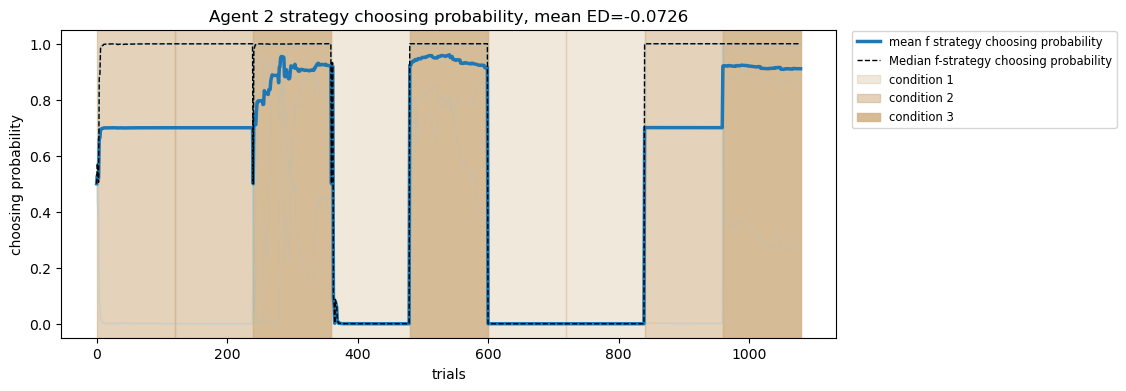

In [2685]:
# Strategy choosing probability iteration
def plot_mean_plan(p_str_list):
    
    ntot = int(p_str_list[0].size(0))
    niter = len(p_str_list)
    tot = torch.arange(ntot)
    p_f_list = []
    plt.figure(figsize=(10,4))
    
    for p_str in p_str_list:
        p_f_list.append(p_str[:, 0])
        plt.plot(tot, p_str[:, 0], alpha = 0.1, color = light_blue, linewidth = 1)

    p_f_str = torch.stack(p_f_list)
    p_str_mean = torch.mean(p_f_str, dim=0)
    p_str_median = torch.median(p_f_str, dim=0).values
    #p_str_25 = torch.quantile(p_f_str, 0.25, dim=0)  # 25th percentile (Q1)
    #p_str_75 = torch.quantile(p_f_str, 0.75, dim=0)  # 75th percentile (Q3)
    
    plt.plot(tot, p_str_mean, label='mean f strategy choosing probability', color = sea, linewidth = 2.5)
    plt.plot(tot, p_str_median, label='Median f-strategy choosing probability', color= 'black', linestyle='--', linewidth=1)
    #plt.plot(tot, p_str_25, label='25th percentile (Q1)', color='white', linestyle=':', linewidth=2)
    #plt.plot(tot, p_str_75, label='75th percentile (Q3)', color='white', linestyle=':', linewidth=2)
   
plot_mean_plan(p_str_list)
plot_conditions(conditions)
# Add legend outside the plot
plt.legend(fontsize='small', loc=(1.02, 0.68))

plt.title(f'Agent {ag} strategy choosing probability, mean ED={torch.mean(Err_diff):.4f}')
plt.xlabel('trials')
plt.ylabel('choosing probability')
f_name = f'N{expn} Agent {ag} mean strategy choosing(plot all), mean ED={torch.mean(Err_diff):.4f}.png'
if save_fig == 1:
        plt.savefig(os.path.join(output_dir, f_name), dpi=300, bbox_inches='tight')

# Adjust the layout to make room for the legend
#plt.tight_layout()
plt.show()

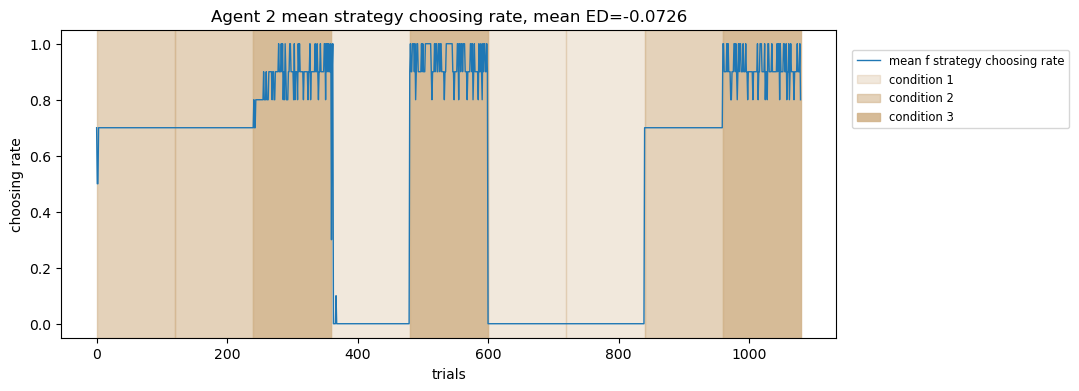

In [2686]:
# Strategy choosing rate
def plot_mean_str(str_list):
    
    ntot = int(str_list[0].size(0))
    tot = torch.arange(ntot)
    
    plt.figure(figsize=(10,4))
    
    str_l = 1 - torch.stack(str_list).float()
    str_mean = torch.mean(str_l, dim=0)
    #p_str_median = torch.median(str_l, dim=0).values
    #p_str_25 = torch.quantile(p_f_str, 0.25, dim=0)  # 25th percentile (Q1)
    #p_str_75 = torch.quantile(p_f_str, 0.75, dim=0)  # 75th percentile (Q3)
    
    plt.plot(tot, str_mean, label='mean f strategy choosing rate', color = sea, linewidth = 1)
    #plt.plot(tot, p_str_median, label='Median f-strategy choosing probability', color= light_blue, linestyle='--', linewidth=2)
    #plt.plot(tot, p_str_25, label='25th percentile (Q1)', color='white', linestyle=':', linewidth=2)
    #plt.plot(tot, p_str_75, label='75th percentile (Q3)', color='white', linestyle=':', linewidth=2)
   
plot_mean_str(str_list)
plot_conditions(conditions)
# Add legend outside the plot
plt.ylim(-0.05, 1.05)
plt.legend(fontsize='small', loc=(1.02, 0.68))

plt.title(f'Agent {ag} mean strategy choosing rate, mean ED={torch.mean(Err_diff):.4f}')
plt.xlabel('trials')
plt.ylabel('choosing rate')
f_name = f'N{expn} Agent {ag} mean strategy choosing rate, mean ED={torch.mean(Err_diff):.4f}.png'
if save_fig == 1:
        plt.savefig(os.path.join(output_dir, f_name), dpi=300, bbox_inches='tight')

# Adjust the layout to make room for the legend
#plt.tight_layout()
plt.show()

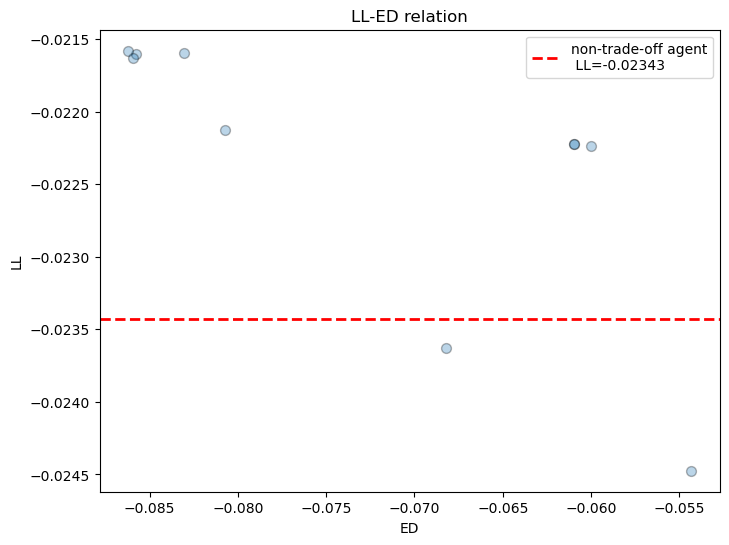

In [2687]:
# Plot LL-ED relation

plt.figure(figsize=(8, 6))
plt.scatter(Err_diff, Lg_like, s=50, c=sea, edgecolor='k', alpha=0.3)
plt.title('LL-ED relation')
plt.xlabel('ED')
plt.ylabel('LL')
#plt.xlim(-0.1, -0.07)
plt.axhline(y=Train_ll_0[agn], color='red', linestyle='--', linewidth=2, label=f'non-trade-off agent\n LL={Train_ll_0[agn]:.5f}')
#plt.axhline(y=Train_ll[-1][1], color='orange', linestyle='--', linewidth=2, label='static belief agent')
plt.legend()

plt.savefig(os.path.join(output_dir, f'N{expn} Agent{ag} LL--ED.png'), dpi=300, bbox_inches='tight')

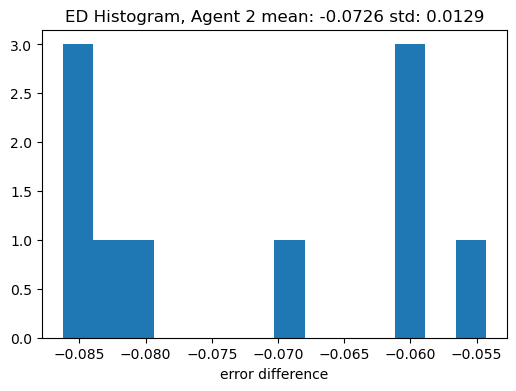

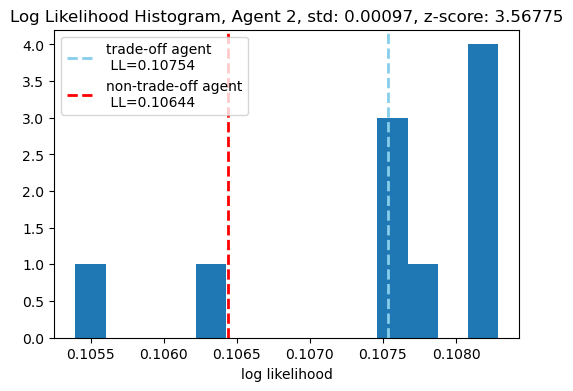

In [2688]:
# Plot training result, (Before plotting, get the referece value Train_ll_1 of a no-update agent and the rival value from non-trade-off 
# Bayesian agent Train_ll_0 in advance)

agn = 0
plt.figure(figsize=(6, 4))
#rsm_ED = torch.sqrt(torch.std(Err_diff) ** 2 + torch.mean(Err_diff) ** 2)
std_ED = torch.std(Err_diff, unbiased=True)
plt.title(f'ED Histogram, Agent {ag} mean: {torch.mean(Err_diff):.4f} std: {std_ED:.4f}')
plt.xlabel('error difference')
plt.hist(Err_diff, bins=14)
plt.savefig(os.path.join(output_dir, f'N{expn} Agent {ag}_mean_{torch.mean(Err_diff):.4f}_std_{std_ED:.4f}_ED_Histogram.png'), dpi=300, bbox_inches='tight')

std_s = torch.std(Lg_like-Train_ll_1[agn], unbiased=True)
z_score = (torch.mean(Lg_like) - Train_ll_0[agn]) / (std_s / torch.sqrt(torch.tensor(len(Lg_like))))

plt.figure(figsize=(6, 4))
plt.title(f'Log Likelihood Histogram, Agent {ag}, std: {std_s:.5f}, z-score: {z_score:.5f}')
plt.xlabel('log likelihood')
plt.hist(Lg_like - Train_ll_1[agn], bins=14)

plt.axvline(x=torch.mean(Lg_like)-Train_ll_1[agn], color=light_blue, linestyle='--', linewidth=2, label=f'trade-off agent\n LL={torch.mean(Lg_like)-Train_ll_1[agn]:.5f}')
plt.axvline(x=Train_ll_0[agn]-Train_ll_1[agn], color='red', linestyle='--', linewidth=2, label=f'non-trade-off agent\n LL={Train_ll_0[agn]-Train_ll_1[agn]:.5f}')
#plt.axvline(x=Train_ll_1[-1], color='orange', linestyle='--', linewidth=2, label=f'static belief agent\n LL={Train_ll_1[-1]:.5f}')
plt.legend()
plt.savefig(os.path.join(output_dir, f'N{expn} Agent {ag}_mean_{torch.mean(Lg_like):.4f}_LL_Histogram.png'), dpi=300, bbox_inches='tight')

In [2493]:
#Play test trials, get LL, ED, strategy choosing probability lists

agent.update = True # True for dynamic testing, False for Static testing
agent.ni = 2
ni = 2
n_it = len(last_belief_md_list)
diff_list = zeros(n_it)
ll_list = zeros(n_it)
p_str_test_list = []

agent_data = torch_data[torch.where(torch_data[:, 0] == ag)[0][1080:], :]

nb = 18

conditions = zeros(nb)
questions = zeros(nb, nt)
reaction_times = zeros(nb, nt)
errors = zeros(nb, nt)

count = 0
count_f = 0
count_c = 0
mean_f_error = 0
mean_c_error = 0

f_e = []
c_e = []

for b in torch.arange(nb):
    conditions[b] =  get_condition(agent_data[count, 2])

    for t in torch.arange(nt):
        questions[b, t] = get_question(agent_data[count, 3])

        if questions[b, t] == 1:
            reaction_times[b, t] = agent_data[count, 11] 
            errors[b, t] = agent_data[count, 10]
            if ~torch.isnan(errors[b, t]):
                mean_c_error += errors[b, t]
                c_e.append(errors[b, t])
                count_c += 1
        elif questions[b, t] == 0:
            errors[b, t] = agent_data[count, 7] * torch.pi / 180
            if ~torch.isnan(errors[b, t]):
                mean_f_error += errors[b, t]
                f_e.append(errors[b, t])
                count_f += 1
        count += 1

mean_f_error = mean_f_error / count_f
mean_c_error = mean_c_error / count_c

f_error = torch.stack(f_e)
c_error = torch.stack(c_e)

std_f_error = torch.std(f_error)
std_c_error = torch.std(c_error)

data_test = {}
data_test['conditions'] = conditions #(b)
data_test['questions'] = questions#(b, t)
data_test['reaction_times'] = reaction_times #(b, t)
data_test['errors'] = errors
data_test['mean_f_error'] = mean_f_error
data_test['mean_c_error'] = mean_c_error
data_test['std_f_error'] = std_f_error
data_test['std_c_error'] = std_c_error

agent.eF_cri = mean_f_error
agent.eC_cri = mean_c_error

for kk in range(n_it):

    last_belief_md = last_belief_md_list[kk]
    last_belief_me = last_belief_me_list[kk]

    agent.plan_str = []
    if agent.d_con:
        for c in range(nc):
            for i in range(ni):
                for w in range(nw):
                    agent.belief_md[(c, i, w)] = [last_belief_md[(c, i, w)].clone()]
    if agent.e_con:
        for c in range(nc):
            for i in range(ni):
                for w in range(nw):
                    agent.belief_me[(c, i, w)] = [last_belief_me[(c, i, w)].clone()]
            
    simulator = Simulator_Behavior(data=data_test, agents=agent, conditions=3, blocks=nb, trials=120)
    simulator.simulate_experiment()


    diff = simulator.error_diff.clone()
    ll = simulator.lglike_mean.clone()
    diff_list[kk] = diff
    ll_list[kk] = ll
    p_str_test_list.append(agent.plan_str)
   
    print(kk)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


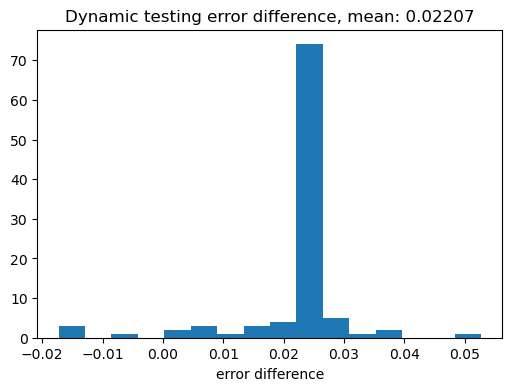

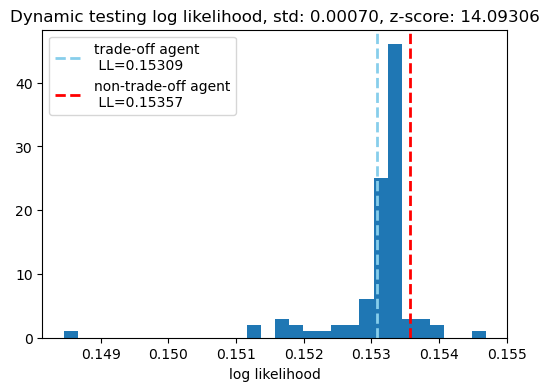

In [2494]:
# Plot static test result, (Before plotting, get the referece value Test_ll_1 of a no-update agent and the rival value from non-trade-off 
# Bayesian agent Static_test_ll_0 (for static testing), Test_ll_0 (for dynamic testing) in advance)

plt.figure(figsize=(6, 4))
plt.hist(diff_list, bins=16)
m_diff = torch.mean(diff_list)
plt.xlabel('error difference')
plt.title(f'Dynamic testing error difference, mean: {m_diff:.5f}')
plt.savefig(os.path.join(output_dir, f'N{expn} Agent{ag} dynamic testing, mean ED {m_diff:.5f} Histogram.png'), dpi=300, bbox_inches='tight')

std_ll = torch.std(ll_list - Test_ll_1[-1], unbiased=True)
z_score_ll = (torch.mean(ll_list) - Test_ll_0[-1]) / (std_s / torch.sqrt(torch.tensor(len(ll_list))))

plt.figure(figsize=(6, 4))
plt.hist(ll_list - Test_ll_1[-1], bins=30)

plt.axvline(x=torch.mean(ll_list)-Test_ll_1[-1], color=light_blue, linestyle='--', linewidth=2, label=f'trade-off agent\n LL={torch.mean(ll_list)-Test_ll_1[-1]:.5f}')
plt.axvline(x=Test_ll_0[-1]-Test_ll_1[-1], color='red', linestyle='--', linewidth=2, label=f'non-trade-off agent\n LL={Test_ll_0[-1]-Test_ll_1[-1]:.5f}')
plt.legend()

plt.xlabel('log likelihood')
plt.title(f'Dynamic testing log likelihood, std: {std_ll:.5f}, z-score: {z_score_ll:.5f}')
plt.savefig(os.path.join(output_dir, f'N{expn} Agent{ag} dynamic testing, mean LL {m_ll:.5f}_Histogram.png'), dpi=300, bbox_inches='tight')

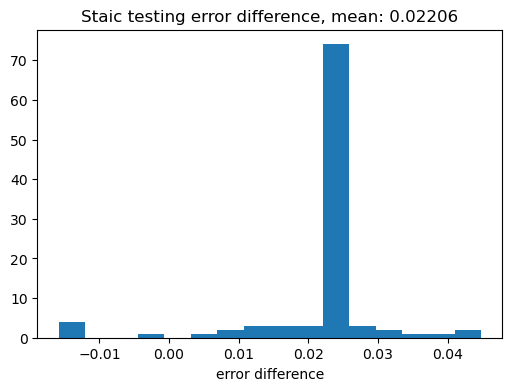

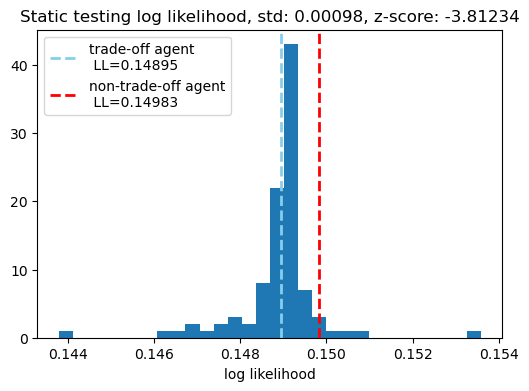

In [2492]:
# Plot dynamic test result, (Before plotting, get the referece value Test_ll_1 of a no-update agent and the rival value from non-trade-off 
# Bayesian agent Static_test_ll_0 (for static testing), Test_ll_0 (for dynamic testing) in advance)

plt.figure(figsize=(6, 4))
plt.hist(diff_list, bins=16)
m_diff = torch.mean(diff_list)
plt.xlabel('error difference')
plt.title(f'Staic testing error difference, mean: {m_diff:.5f}')
plt.savefig(os.path.join(output_dir, f'N{expn} Agent{ag} static testing, mean ED {m_diff:.5f} Histogram.png'), dpi=300, bbox_inches='tight')

std_ll = torch.std(ll_list - Test_ll_1[-1], unbiased=True)
z_score_ll = (torch.mean(ll_list) - Static_test_ll_0[-1]) / (std_s / torch.sqrt(torch.tensor(len(ll_list))))

plt.figure(figsize=(6, 4))
plt.hist(ll_list - Test_ll_1[-1], bins=30)

plt.axvline(x=torch.mean(ll_list)-Test_ll_1[-1], color=light_blue, linestyle='--', linewidth=2, label=f'trade-off agent\n LL={torch.mean(ll_list)-Test_ll_1[-1]:.5f}')
plt.axvline(x=Static_test_ll_0[-1]-Test_ll_1[-1], color='red', linestyle='--', linewidth=2, label=f'non-trade-off agent\n LL={Static_test_ll_0[-1]-Test_ll_1[-1]:.5f}')
#plt.axvline(x=Test_ll_1[-1], color='orange', linestyle='--', linewidth=2, label=f'static belief agent\n LL={Test_ll_1[-1]:.5f}')
plt.legend()

plt.xlabel('log likelihood')
plt.title(f'Static testing log likelihood, std: {std_ll:.5f}, z-score: {z_score_ll:.5f}')
plt.savefig(os.path.join(output_dir, f'N{expn} Agent{ag} static testing, mean LL {m_ll:.5f}_Histogram.png'), dpi=300, bbox_inches='tight')

In [2457]:
#non-meta agent (the same as 'Play training trials', but with non-trade-off setting and simple result only provide ED and LL)
agent.update = True
agent.ni = 1
nb = 9
expn += 1
n_it = 3
Err_diff_0 = zeros(n_it)
Lg_like_0 = zeros(n_it)
p_str_list_0 = []
str_list_0 = []
last_belief_md_list_0 = []
last_belief_me_list_0 = []

for kk in range(n_it):
    
    agent.initiate_prior_plan_strategy()
    if agent.d_con:
        agent.initiate_md_distribution()
    if agent.e_con:
        agent.initiate_me_distribution() 
    
    simulator = Simulator_Behavior(data=data, agents=agent, conditions=3, blocks=9, trials=120)
    simulator.simulate_experiment()

    Err_diff_0[kk] = simulator.error_diff
    Lg_like_0[kk] = simulator.lglike_mean
    p_str = torch.stack(agent.plan_str)
    p_str_list_0.append(p_str)
    strs = torch.stack(simulator.strs)
    str_list_0.append(strs)

    last_belief_md_0 = {}
    last_belief_me_0 = {}

    for c in range(nc):
            for i in range(1):
                    for w in range(nw):
                        last_belief_md_0[(c, i, w)] = agent.belief_md[(c, i, w)][-1].clone()
                        last_belief_me_0[(c, i, w)] = agent.belief_me[(c, i, w)][-1].clone()

    last_belief_md_list_0.append(last_belief_md_0)
    last_belief_me_list_0.append(last_belief_me_0)

    print(kk)

print(Err_diff_0)
print(Lg_like_0)

0
1
2
tensor([-1.7179e-07, -1.7179e-07, -1.7179e-07])
tensor([0.0505, 0.0505, 0.0505])


In [2460]:
#non-meta agent test trial (the same as 'Play test trials', but with non-trade-off agent setting and simple result only provide ED and LL)
agent.update = False
agent.ni = 1
n_it = len(last_belief_md_list_0)
diff_list_0 = zeros(n_it)
ll_list_0 = zeros(n_it)
p_str_test_list_0 = []
for kk in range(n_it):

    last_belief_md_0 = last_belief_md_list_0[kk]
    last_belief_me_0 = last_belief_me_list_0[kk]

    agent_data = torch_data[torch.where(torch_data[:, 0] == ag)[0][1080:], :]
    
    nb = 18

    conditions = zeros(nb)
    questions = zeros(nb, nt)
    reaction_times = zeros(nb, nt)
    errors = zeros(nb, nt)

    count = 0
    count_f = 0
    count_c = 0
    mean_f_error = 0
    mean_c_error = 0

    f_e = []
    c_e = []

    for b in torch.arange(nb):
        conditions[b] =  get_condition(agent_data[count, 2])

        for t in torch.arange(nt):
            questions[b, t] = get_question(agent_data[count, 3])

            if questions[b, t] == 1:
                reaction_times[b, t] = agent_data[count, 11] 
                errors[b, t] = agent_data[count, 10]
                if ~torch.isnan(errors[b, t]):
                    mean_c_error += errors[b, t]
                    c_e.append(errors[b, t])
                    count_c += 1
            elif questions[b, t] == 0:
                errors[b, t] = agent_data[count, 7] * torch.pi / 180
                if ~torch.isnan(errors[b, t]):
                    mean_f_error += errors[b, t]
                    f_e.append(errors[b, t])
                    count_f += 1
            count += 1

    mean_f_error = mean_f_error / count_f
    mean_c_error = mean_c_error / count_c

    f_error = torch.stack(f_e)
    c_error = torch.stack(c_e)

    std_f_error = torch.std(f_error)
    std_c_error = torch.std(c_error)

    data_test = {}
    data_test['conditions'] = conditions #(b)
    data_test['questions'] = questions#(b, t)
    data_test['reaction_times'] = reaction_times #(b, t)
    data_test['errors'] = errors
    data_test['mean_f_error'] = mean_f_error
    data_test['mean_c_error'] = mean_c_error
    data_test['std_f_error'] = std_f_error
    data_test['std_c_error'] = std_c_error

    agent.eF_cri = mean_f_error
    agent.eC_cri = mean_c_error

    agent.plan_str = []
    if agent.d_con:
        for c in range(nc):
            for i in range(1):
                for w in range(nw):
                    agent.belief_md[(c, i, w)] = [last_belief_md_0[(c, i, w)].clone()]
    if agent.e_con:
        for c in range(nc):
            for i in range(1):
                for w in range(nw):
                    agent.belief_me[(c, i, w)] = [last_belief_me_0[(c, i, w)].clone()]
            
    simulator = Simulator_Behavior(data=data_test, agents=agent, conditions=3, blocks=nb, trials=120)#, train=False)
    simulator.simulate_experiment()


    diff_0 = simulator.error_diff
    ll_0 = simulator.lglike_mean
    diff_list_0[kk] = diff_0
    ll_list_0[kk] = ll_0
    p_str_test_list_0.append(agent.plan_str)
   
    print(kk)

print(diff_list_0)
print(ll_list_0)

0
1
2
tensor([-7.5267e-08, -7.5267e-08, -7.5267e-08])
tensor([0.0990, 0.0990, 0.0990])


In [2462]:
#prior agent (the same as 'Play training trials', but with non-update (non-Bayesian) setting and simple result only provide ED and LL)
agent.update = False
agent.ni = 1
nb = 9
ni =2
expn += 1
n_it = 3
Err_diff_1 = zeros(n_it)
Lg_like_1 = zeros(n_it)
p_str_list_1 = []
str_list_1 = []
last_belief_md_list_1 = []
last_belief_me_list_1 = []

for kk in range(n_it):
    
    agent.initiate_prior_plan_strategy()
    if agent.d_con:
        agent.initiate_md_distribution()
    if agent.e_con:
        agent.initiate_me_distribution() 
    
    simulator = Simulator_Behavior(data=data, agents=agent, conditions=3, blocks=9, trials=120)
    simulator.simulate_experiment()

    Err_diff_1[kk] = simulator.error_diff
    Lg_like_1[kk] = simulator.lglike_mean
    p_str = torch.stack(agent.plan_str)
    p_str_list_1.append(p_str)
    strs = torch.stack(simulator.strs)
    str_list_1.append(strs)

    last_belief_md_1 = {}
    last_belief_me_1 = {}

    for c in range(nc):
            for i in range(1):
                    for w in range(nw):
                        last_belief_md_1[(c, i, w)] = agent.belief_md[(c, i, w)][-1].clone()
                        last_belief_me_1[(c, i, w)] = agent.belief_me[(c, i, w)][-1].clone()

    last_belief_md_list_1.append(last_belief_md_1)
    last_belief_me_list_1.append(last_belief_me_1)

    print(kk)

print(Err_diff_1)
print(Lg_like_1)

0
1
2
tensor([-1.7179e-07, -1.7179e-07, -1.7179e-07])
tensor([-0.0588, -0.0588, -0.0588])


In [2463]:
#prior agent test trial (the same as 'Play test trials', but with non-update (non-Bayesian) setting and simple result only provide ED and LL)
agent.update = False
agent.ni = 1
n_it = len(last_belief_md_list_1)
diff_list_1 = zeros(n_it)
ll_list_1 = zeros(n_it)
p_str_test_list_1 = []
for kk in range(n_it):

    last_belief_md_1 = last_belief_md_list_1[kk]
    last_belief_me_1 = last_belief_me_list_1[kk]

    agent_data = torch_data[torch.where(torch_data[:, 0] == ag)[0][1080:], :]
    
    nb = 18

    conditions = zeros(nb)
    questions = zeros(nb, nt)
    reaction_times = zeros(nb, nt)
    errors = zeros(nb, nt)

    count = 0
    count_f = 0
    count_c = 0
    mean_f_error = 0
    mean_c_error = 0

    f_e = []
    c_e = []

    for b in torch.arange(nb):
        conditions[b] =  get_condition(agent_data[count, 2])

        for t in torch.arange(nt):
            questions[b, t] = get_question(agent_data[count, 3])

            if questions[b, t] == 1:
                reaction_times[b, t] = agent_data[count, 11] 
                errors[b, t] = agent_data[count, 10]
                if ~torch.isnan(errors[b, t]):
                    mean_c_error += errors[b, t]
                    c_e.append(errors[b, t])
                    count_c += 1
            elif questions[b, t] == 0:
                errors[b, t] = agent_data[count, 7] * torch.pi / 180
                if ~torch.isnan(errors[b, t]):
                    mean_f_error += errors[b, t]
                    f_e.append(errors[b, t])
                    count_f += 1
            count += 1

    mean_f_error = mean_f_error / count_f
    mean_c_error = mean_c_error / count_c

    f_error = torch.stack(f_e)
    c_error = torch.stack(c_e)

    std_f_error = torch.std(f_error)
    std_c_error = torch.std(c_error)

    data_test = {}
    data_test['conditions'] = conditions #(b)
    data_test['questions'] = questions#(b, t)
    data_test['reaction_times'] = reaction_times #(b, t)
    data_test['errors'] = errors
    data_test['mean_f_error'] = mean_f_error
    data_test['mean_c_error'] = mean_c_error
    data_test['std_f_error'] = std_f_error
    data_test['std_c_error'] = std_c_error

    agent.eF_cri = mean_f_error
    agent.eC_cri = mean_c_error

    agent.plan_str = []
    if agent.d_con:
        for c in range(nc):
            for i in range(1):
                for w in range(nw):
                    agent.belief_md[(c, i, w)] = [last_belief_md_1[(c, i, w)].clone()]
    if agent.e_con:
        for c in range(nc):
            for i in range(1):
                for w in range(nw):
                    agent.belief_me[(c, i, w)] = [last_belief_me_1[(c, i, w)].clone()]
            
    simulator = Simulator_Behavior(data=data_test, agents=agent, conditions=3, blocks=nb, trials=120)#, train=False)
    simulator.simulate_experiment()


    diff_1 = simulator.error_diff
    ll_1 = simulator.lglike_mean
    diff_list_1[kk] = diff_1
    ll_list_1[kk] = ll_1
    p_str_test_list_1.append(agent.plan_str)
   
    print(kk)

print(diff_list_1)
print(ll_list_1)

0
1
2
tensor([-7.5267e-08, -7.5267e-08, -7.5267e-08])
tensor([-0.0508, -0.0508, -0.0508])


In [1988]:
Lg_like_1

tensor([-0.1299, -0.1299, -0.1299])

In [2090]:
# Initialize lists to save refernce model data

Train_ll_0 = [] # LL of non-trade-off Bayesian agent training
Test_ll_0 = [] # LL of non-trade-off Bayesian agent dynamic testing
Static_test_ll_0 = [] # LL of non-trade-off Bayesian agent static testing
Train_ll_1 = [] # LL of non-Bayesian agent training
Test_ll_1 = [] # LL of non-Bayesian agent testing

In [2459]:
# Append LL of non-trade-off Bayesian agent after training and dynamic testing
Train_ll_0.append(Lg_like_0[0])
Test_ll_0.append(ll_list_0[0])
print(Train_ll_0, Test_ll_0)

[tensor(-0.0234), tensor(-0.1838), tensor(0.0505)] [tensor(0.2087), tensor(-0.0918), tensor(0.1028)]


In [2461]:
# Append LL of non-trade-off Bayesian agent after static testing
Static_test_ll_0.append(ll_list_0[0])
print(Static_test_ll_0)

[tensor(0.1730), tensor(-0.1122), tensor(0.0990)]


In [2464]:
# Append LL of non-Bayesian agent
Train_ll_1.append(Lg_like_1[0])
Test_ll_1.append(ll_list_1[0])
print(Train_ll_1, Test_ll_1)

[tensor(-0.1299), tensor(-0.1527), tensor(-0.0588)] [tensor(-0.0202), tensor(-0.1065), tensor(-0.0508)]


In [1995]:
simulator.lglike_mean, simulator.num_d, simulator.num_e

(tensor(0.1730), 1080, 2138)

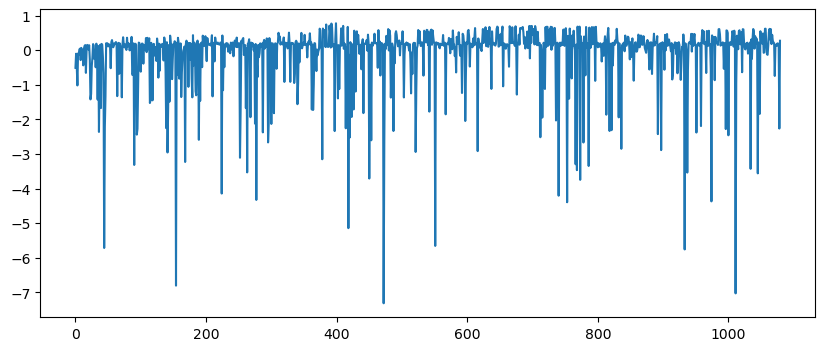

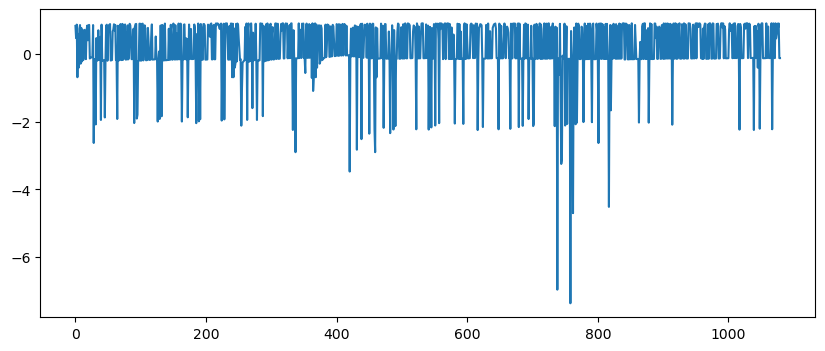

In [1545]:
#plot evidence evolution

evi_d = torch.stack(agent.evi_d_list)
evi_e = torch.stack(agent.evi_e_list)

dni = torch.where(~torch.isnan(evi_d))
eni = torch.where(~torch.isnan(evi_e))
tot = torch.arange(1080)
plt.figure(figsize=(10,4))
plt.plot(tot[dni], torch.log(evi_d[dni]))
plt.figure(figsize=(10,4))
plt.plot(tot[eni], torch.log(evi_e[eni]))

In [1468]:
simulator.error_diff, simulator.error_al, simulator.error_op

(tensor(-0.1066), tensor(-0.0532), tensor(0.0535))

In [1308]:
# Separately set test data (seldom used)
agent_data = torch_data[torch.where(torch_data[:, 0] == ag)[0][1080:], :]

nb = 18

conditions = zeros(nb)
questions = zeros(nb, nt)
reaction_times = zeros(nb, nt)
errors = zeros(nb, nt)

count = 0
count_f = 0
count_c = 0
mean_f_error = 0
mean_c_error = 0

f_e = []
c_e = []

for b in torch.arange(nb):
    conditions[b] =  get_condition(agent_data[count, 2])

    for t in torch.arange(nt):
        questions[b, t] = get_question(agent_data[count, 3])

        if questions[b, t] == 1:
            reaction_times[b, t] = agent_data[count, 11] 
            errors[b, t] = agent_data[count, 10]
            if ~torch.isnan(errors[b, t]):
                mean_c_error += errors[b, t]
                c_e.append(errors[b, t])
                count_c += 1
        elif questions[b, t] == 0:
            errors[b, t] = agent_data[count, 7] * torch.pi / 180
            if ~torch.isnan(errors[b, t]):
                mean_f_error += errors[b, t]
                f_e.append(errors[b, t])
                count_f += 1
        count += 1

mean_f_error = mean_f_error / count_f
mean_c_error = mean_c_error / count_c

f_error = torch.stack(f_e)
c_error = torch.stack(c_e)

std_f_error = torch.std(f_error)
std_c_error = torch.std(c_error)

data_test = {}
data_test['conditions'] = conditions #(b)
data_test['questions'] = questions#(b, t)
data_test['reaction_times'] = reaction_times #(b, t)
data_test['errors'] = errors
data_test['mean_f_error'] = mean_f_error
data_test['mean_c_error'] = mean_c_error
data_test['std_f_error'] = std_f_error
data_test['std_c_error'] = std_c_error

agent.eF_cri = mean_f_error
agent.eC_cri = mean_c_error

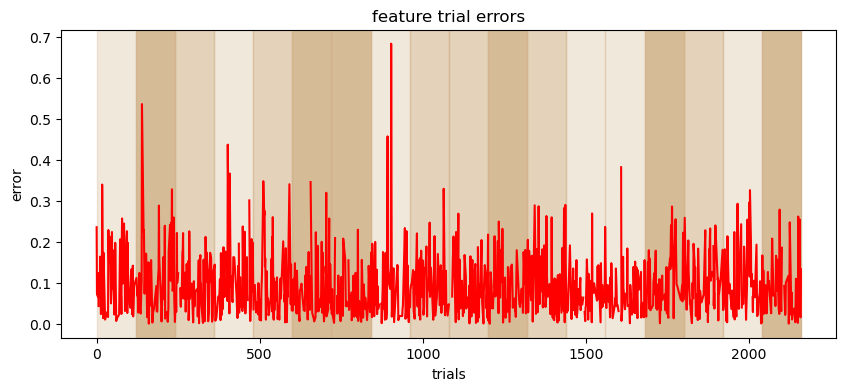

In [1329]:
#plot error (seldom used)
plt.figure(figsize=(10, 4))
Errors = torch.flatten(errors)
Questions = torch.flatten(questions)
plt.title('feature trial errors')
plt.xlabel('trials')
plt.ylabel('error')
ntot = len(Errors[torch.where(Questions==0)])
plt.plot(torch.where(Questions==0)[0], Errors[torch.where(Questions==0)], color = 'red')
plot_conditions(conditions)

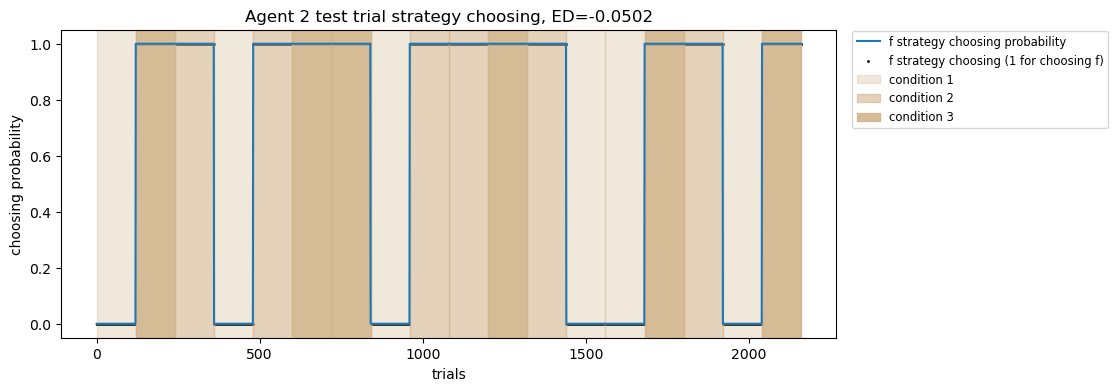

In [2189]:
plot_plan(p_str_test_list[27], simulator.strs, simulator.error_diff, ag=ag, f_name = f'N{expn}, Agent {ag} ED={simulator.error_diff:.4f} Fitted gent_strategy_choosing.png', save_fig = save_fig)

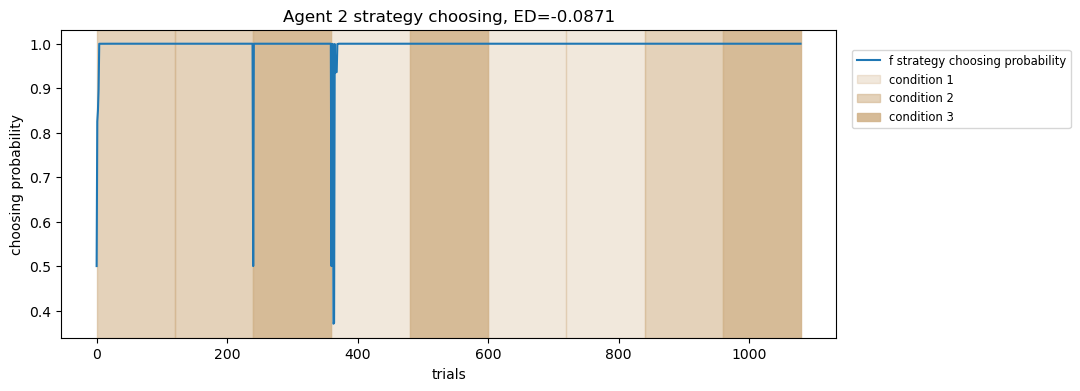

In [1685]:
# original strategy choosing probability (after doing test trial, you can run 'Settle behaviour data to be input into the simulator' again and
# run this to get back certain training simulation)
def plot_plan(plan_str, strs, ED , ag, f_name = f'default', save_fig = 0):
    p_str = plan_str#torch.stack(plan_str)
    tot = torch.arange(p_str.size(0))
    plt.figure(figsize=(10,4))
    plt.plot(tot, p_str[:, 0], color=sea, label='f strategy choosing probability')

    #plt.plot(tot, p_str[:, 1], label='c strategy choosing')
    #for b, k in enumerate(range(0, p_str.size(0), nt)):

    strategies = torch.stack(strs)
    tot1 = torch.arange(strategies.size(0))
    #plt.scatter(tot1, 1-strategies, color='black', s=1, label='f strategy choosing (1 for choosing f)')

    c0 = torch.where(conditions==0)[0] * 120
    c1 = torch.where(conditions==1)[0] * 120
    c2 = torch.where(conditions==2)[0] * 120

    # Initialize flags to ensure labels are only added once
    label_c0_added = False
    label_c1_added = False
    label_c2_added = False

    color = sandy
    for loc in c0:
        if not label_c0_added:
            plt.axvspan(xmin=loc, xmax=loc+120, color=color, alpha=0.3, label='condition 1')
            label_c0_added = True
        else:
            plt.axvspan(xmin=loc, xmax=loc+120, color=color, alpha=0.3)

    for loc in c1:
        if not label_c1_added:
            plt.axvspan(xmin=loc, xmax=loc+120, color=color, alpha=0.6, label='condition 2')
            label_c1_added = True
        else:
            plt.axvspan(xmin=loc, xmax=loc+120, color=color, alpha=0.6)

    for loc in c2:
        if not label_c2_added:
            plt.axvspan(xmin=loc, xmax=loc+120, color=color, alpha=0.9, label='condition 3')
            label_c2_added = True
        else:
            plt.axvspan(xmin=loc, xmax=loc+120, color=color, alpha=0.9)

    # Add legend outside the plot
    plt.legend(fontsize='small', loc=(1.02, 0.68))

    plt.title(f'Agent {ag} strategy choosing, ED={ED:.4f}')
    plt.xlabel('trials')
    plt.ylabel('choosing probability')
    if save_fig == 1:
            plt.savefig(os.path.join(output_dir, f_name), dpi=300, bbox_inches='tight')

    # Adjust the layout to make room for the legend
    #plt.tight_layout()
    plt.show()

plot_plan(p_str_list[22], simulator.strs, simulator.error_diff, ag=ag, f_name = f'N{expn}, Agent {ag} ED={simulator.error_diff:.4f} Fitted gent_strategy_choosing.png', save_fig = save_fig)

In [213]:
# Fitting help function

def get_mean_diff(agent, data, conditions, blocks, trials, niter = 5, param_name = None, param_shifted = None):
    diff_mean = 0
    for n in range(niter):
        diff = 1
        while diff>=0:
            if param_name != None:
                setattr(agent, param_name, param_shifted)

            agent.initiate_prior_plan_strategy()
            if agent.d_con:
                agent.initiate_md_distribution()
            if agent.e_con:
                agent.initiate_me_distribution()

            simulator = Simulator_Behavior(data=data, agents=agent, conditions=conditions, blocks=blocks, trials=trials)
            simulator.simulate_experiment()

            diff = simulator.error_diff
        #print(simulator.error_diff)
        diff_mean += diff
    diff_mean /= niter
    #plot_plan(agent.plan_str, simulator.strs, simulator.error_diff, f_name = f'default', save_fig = 0)
    return diff_mean


def get_mean_ll(agent, data, conditions, blocks, trials, niter = 5, param_name = None, param_shifted = None):
    
    agent.ni = 2

    if param_name != None:
                if param_name == 'beta' or param_name == 'gamma':
                    param_shifted = torch.exp(param_shifted)
                
                setattr(agent, param_name, param_shifted)
    
    ll_mean = 0
    
    for n in range(niter):
        diff = 1
        while diff>=-0.05:
            agent.initiate_prior_plan_strategy()
            if agent.d_con:
                agent.initiate_md_distribution()
            if agent.e_con:
                agent.initiate_me_distribution()

            simulator = Simulator_Behavior(data=data, agents=agent, conditions=conditions, blocks=blocks, trials=trials)
            simulator.simulate_experiment()

            diff = simulator.error_diff
        #print(simulator.error_diff)
        ll_mean += simulator.lglike_mean
    ll_mean /= niter
    #plot_plan(agent.plan_str, simulator.strs, simulator.error_diff, f_name = f'default', save_fig = 0)
    return ll_mean


def get_no_meta_ll(agent, data, conditions, blocks, trials, param_name = None, param_shifted = None):
    
    agent.ni = 1

    if param_name != None:
                if param_name == 'beta' or param_name == 'gamma':
                    param_shifted = torch.exp(param_shifted)
                
                setattr(agent, param_name, param_shifted)
    
    agent.initiate_prior_plan_strategy()
    if agent.d_con:
        agent.initiate_md_distribution()
    if agent.e_con:
        agent.initiate_me_distribution()

    simulator = Simulator_Behavior(data=data, agents=agent, conditions=conditions, blocks=blocks, trials=trials)
    simulator.simulate_experiment()
    ll = simulator.lglike_mean
    #plot_plan(agent.plan_str, simulator.strs, simulator.error_diff, f_name = f'default', save_fig = 0)
    return ll


def finite_difference_optimization(agent, data, conditions, blocks, trials, num_epochs=10, learning_rate=torch.tensor([1, 1]), pert = torch.tensor([0.1, 0.1])):
    course = {'loss': [], 'loss_none': [], 'grad_sq': []}
    r_list = {}
    r_list['beta'] = [agent.beta.clone()]
    r_list['gamma'] = [agent.gamma.clone()]
    #r_list['lgdm_ff'] = [agent.lgdm_ff.clone()]
    #r_list['lgdm_cf'] = [agent.lgdm_cf.clone()]
   
    for epoch in range(num_epochs):
        print(f'beta:{agent.beta}, gamma:{agent.gamma}')#, lgdm_ff:{agent.lgdm_ff}, lgdm_cf:{agent.lgdm_cf}')
        # Initialize parameter perturbations
        gradients = {}
        count_1 = 0
        for param_name in ['beta', 'gamma']:#, 'lgdm_ff', 'lgdm_cf']:
            param = getattr(agent, param_name)
            if param_name =='beta' or param_name == 'gamma':
                param = torch.log(param)
            perturbation = pert[count_1]  # Small perturbation
            param_plus = param + perturbation
            param_minus = param - perturbation

            # Evaluate loss for perturbed parameters (MINUS for ll, PLUS for ED !!!!!!!!!!!!!)
            loss_plus = - get_mean_ll(agent, data, conditions, blocks, trials, niter = 10, param_name = param_name, param_shifted = param_plus) 
            #########################################################(niter is the interation number of calculating LL)

            loss_minus = - get_mean_ll(agent, data, conditions, blocks, trials, niter = 10, param_name = param_name, param_shifted = param_minus)

            # Compute numerical gradient
            gradient = (loss_plus - loss_minus) / (2 * perturbation)
            gradients[param_name] = gradient

            # Restore original parameter, important! main environment agent will be updated even in function body after the function excecuting is over
            if param_name =='beta' or param_name == 'gamma':
                param = torch.exp(param)
            setattr(agent, param_name, param)

            count_1 += 1
        
        # Update parameters
        count = 0
        grad_sq = 0
        for param_name, gradient in gradients.items():
            param = getattr(agent, param_name)
            if param_name =='beta' or param_name == 'gamma':
                param.data = torch.exp(torch.log(param.data) - learning_rate[count] * gradient)
            else:
                param.data -= learning_rate[count] * gradient
            grad_sq += gradient**2

            print(param_name, learning_rate[count] * gradient)
            count += 1

        loss = - get_mean_ll(agent, data, conditions, blocks, trials, niter = 5)
        #loss_none = - get_no_meta_ll(agent, data, conditions, blocks, trials)
        # Print progress
        print(f'beta:{agent.beta}, gamma:{agent.gamma}')#, lgdm_ff:{agent.lgdm_ff}, lgdm_cf:{agent.lgdm_cf}')
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss}')#, Loss comparison: {loss_none}')
        print(f'Gradient square: {grad_sq}')
        
        r_list['beta'].append(agent.beta.clone())
        r_list['gamma'].append(agent.gamma.clone())
        #r_list['lgdm_ff'].append(agent.lgdm_ff.clone())
        #r_list['lgdm_cf'].append(agent.lgdm_cf.clone())
        course['grad_sq'].append(grad_sq)
        course['loss'].append(loss)
        #course['loss_none'].append(loss_none)

    return agent, r_list, course


In [2508]:
#Fitting!
agent, r_list_a2_ll_42, course_a2_42 = finite_difference_optimization(agent=agent, data=data, conditions=3, blocks=9, trials=120, num_epochs=20, learning_rate=torch.tensor([10, 10]), pert = torch.tensor([0.1, 0.1]))

beta:8.593804359436035, gamma:10.676996231079102
beta tensor(0.0317)
gamma tensor(0.0241)
beta:8.325785636901855, gamma:10.422331809997559
Epoch 1/20, Loss: 0.01925266906619072
Gradient square: 1.586653888807632e-05
beta:8.325785636901855, gamma:10.422331809997559
beta tensor(0.0720)
gamma tensor(-0.0628)
beta:7.747034549713135, gamma:11.09784984588623
Epoch 2/20, Loss: 0.02169976755976677
Gradient square: 9.134737047133967e-05
beta:7.747034549713135, gamma:11.09784984588623
beta tensor(-0.0344)
gamma tensor(-0.1211)
beta:8.018553733825684, gamma:12.526994705200195
Epoch 3/20, Loss: 0.02190312184393406
Gradient square: 0.00015860232815612108
beta:8.018553733825684, gamma:12.526994705200195
beta tensor(-0.0675)
gamma tensor(0.0421)
beta:8.578706741333008, gamma:12.010035514831543
Epoch 4/20, Loss: 0.023122094571590424
Gradient square: 6.335691432468593e-05
beta:8.578706741333008, gamma:12.010035514831543
beta tensor(-0.0713)
gamma tensor(0.0260)
beta:9.21309757232666, gamma:11.701901435

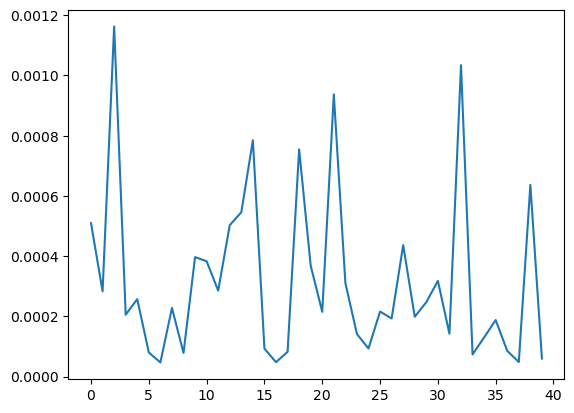

In [2285]:
plt.plot(range(len(course_list_914[2]['grad_sq'])), torch.stack(course_list_914[0]['grad_sq']))

In [2291]:
course_list_914[2]['loss'][9]

tensor(0.1800)

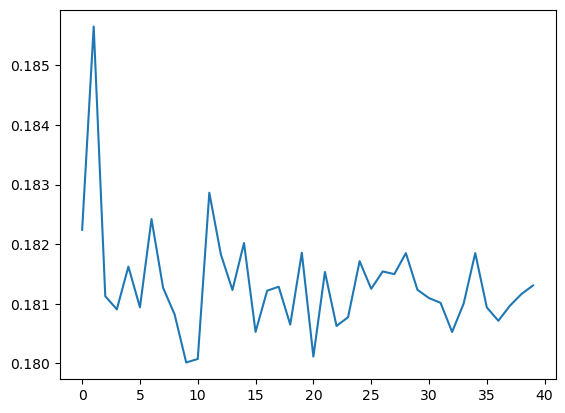

In [2284]:
plt.plot(torch.stack(course_list_914[2]['loss']))

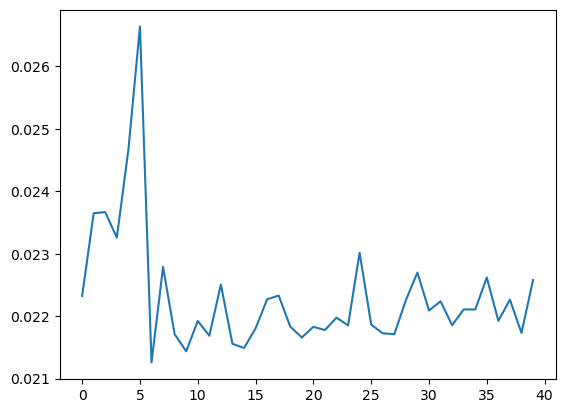

In [1811]:
plt.plot(torch.cat((torch.stack(course_a2_31['loss']), torch.stack(course_a2_32['loss'])), dim=0))

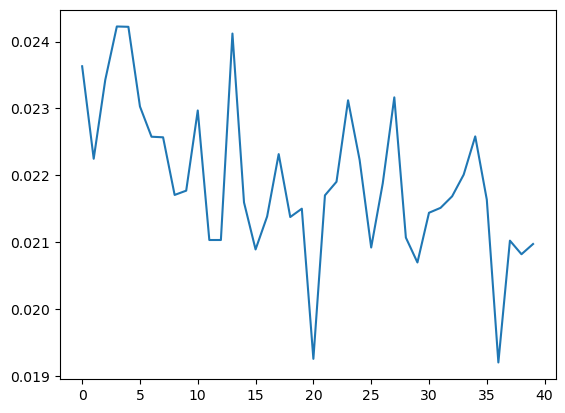

In [2514]:
plt.plot(torch.cat((torch.stack(course_a2_41['loss']), torch.stack(course_a2_42['loss'])), dim=0))

In [1915]:
agent.ni

2

In [1924]:
#Agent-wise fit
r_list_list_914 = []
course_list_914 = []
for ag in [1, 6, 10, 12]:
    agent_data = torch_data[torch.where(torch_data[:, 0] == ag)[0][:1080], :]

    conditions = zeros(nb)
    questions = zeros(nb, nt)
    reaction_times = zeros(nb, nt)
    errors = zeros(nb, nt)

    count = 0
    count_f = 0
    count_c = 0
    mean_f_error = 0
    mean_c_error = 0

    f_e = []
    c_e = []

    for b in torch.arange(nb):
        conditions[b] =  get_condition(agent_data[count, 2])

        for t in torch.arange(nt):
            questions[b, t] = get_question(agent_data[count, 3])

            if questions[b, t] == 1:
                reaction_times[b, t] = agent_data[count, 11] 
                errors[b, t] = agent_data[count, 10]
                if ~torch.isnan(errors[b, t]):
                    mean_c_error += errors[b, t]
                    c_e.append(errors[b, t])
                    count_c += 1
            elif questions[b, t] == 0:
                errors[b, t] = agent_data[count, 7] * torch.pi / 180
                if ~torch.isnan(errors[b, t]):
                    mean_f_error += errors[b, t]
                    f_e.append(errors[b, t])
                    count_f += 1
            count += 1

    mean_f_error = mean_f_error / count_f
    mean_c_error = mean_c_error / count_c

    f_error = torch.stack(f_e)
    c_error = torch.stack(c_e)

    std_f_error = torch.std(f_error)
    std_c_error = torch.std(c_error)

    fit = {}
    data = {}
    fit = {
    #'mlgd0': torch.log(torch.tensor([[[1.1, 0.9], [1.4, 0.8]],[[1.1, 0.9], [1.4, 0.9]], [[1.1, 0.9], [1.4, 1.0]]])), # Shape (nc, ni, nw)
    #'mlgd0': torch.log(torch.tensor([[[1.4, 0.8], [1.6, 0.6]],[[1.4, 0.8], [1.6, 0.65]], [[1.4, 0.8], [1.6, 0.7]]])), # Shape (nc, ni, nw)
    'mlgd0': torch.log(torch.tensor([[[1.2, 0.8], [1.2, 0.8]],[[1.2, 0.8], [1.2, 0.8]], [[1.2, 0.8], [1.2, 0.8]]])),
    'sigmad0': torch.tensor([[[0.5, 0.5], [0.5, 0.5]],[[0.5, 0.5], [0.5, 0.5]], [[0.5, 0.5], [0.5, 0.5]]]), # Shape (nc, ni, nw)
    'sigma': torch.tensor(0.3),  # d likelihood std
    'gamma': torch.tensor(3.),#1.),#, requires_grad=True),  
    'beta': torch.tensor(6.),#2.),#, requires_grad=True),
    'lgdm_ff': torch.tensor(0.6),#torch.log(torch.tensor(1.4)),#, requires_grad=True)),
    'ds_ff': torch.tensor(0.05), 
    'lgdm_cf': torch.tensor([0.6, 0.6, 0.6]),#torch.log(torch.tensor([1.6, 1.6, 1.6])),#, requires_grad=True)), #for different condition
    'ds_cf': torch.tensor([0.05, 0.05, 0.05]),
    'kappa': torch.tensor(10), #elikelihood acuracy
    'me0': torch.tensor([[0, 0], [0, 0], [0, 0]]),#注意i = 0时的mu其实并非真的平均值， 因为取了half
    'ke0': torch.tensor([[65, 65], [70, 70], [73, 73]]),
    'eF_cri': mean_f_error,
    'eC_cri': mean_c_error
    }

    data['conditions'] = conditions #(b)
    data['questions'] = questions#(b, t)
    data['reaction_times'] = reaction_times #(b, t)
    data['errors'] = errors
    data['mean_f_error'] = mean_f_error
    data['mean_c_error'] = mean_c_error
    data['std_f_error'] = std_f_error
    data['std_c_error'] = std_c_error


    agent = MetaAgent(fit=fit, conditions=nc, blocks=nb, trials=nt, d_con=True, e_con=True)

    agent, r_list, course = finite_difference_optimization(agent=agent, data=data, conditions=3, blocks=9, trials=120, num_epochs=40, learning_rate=torch.tensor([10, 10]), pert = torch.tensor([0.1, 0.1]))
    r_list_list_914.append(r_list)
    course_list_914.append(course)

    print(f'agent {ag} finished')

    


beta:6.0, gamma:3.0
beta tensor(-0.2166)
gamma tensor(-0.0636)
beta:7.45091438293457, gamma:3.196911573410034
Epoch 1/40, Loss: 0.1436249166727066
Gradient square: 0.0005094718653708696
beta:7.45091438293457, gamma:3.196911573410034
beta tensor(0.0801)
gamma tensor(0.1479)
beta:6.877288341522217, gamma:2.7572951316833496
Epoch 2/40, Loss: 0.14092592895030975
Gradient square: 0.00028302756254561245
beta:6.877288341522217, gamma:2.7572951316833496
beta tensor(-0.3005)
gamma tensor(-0.1613)
beta:9.287572860717773, gamma:3.2398736476898193
Epoch 3/40, Loss: 0.14529862999916077
Gradient square: 0.0011628451757133007
beta:9.287572860717773, gamma:3.2398736476898193
beta tensor(0.0846)
gamma tensor(-0.1157)
beta:8.534106254577637, gamma:3.6371872425079346
Epoch 4/40, Loss: 0.14834102988243103
Gradient square: 0.00020539260003715754
beta:8.534106254577637, gamma:3.6371872425079346
beta tensor(-0.0294)
gamma tensor(-0.1576)
beta:8.788615226745605, gamma:4.258141994476318
Epoch 5/40, Loss: 0.143

KeyboardInterrupt: 

In [1935]:
import pickle

# Save to a binary file using pickle
with open("Course list 914", "wb") as file:
    pickle.dump(course_list_914, file)

In [261]:
import pickle

# Save to a binary file using pickle
with open("Result_list_910", "rb") as file:
    r_list_list_load = pickle.load(file)

In [214]:
agent.beta, agent.gamma, agent.lgdm_ff, agent.lgdm_cf, torch.exp(agent.lgdm_ff), torch.exp(agent.lgdm_cf)

(tensor(6.),
 tensor(0.5000),
 tensor(0.6000),
 tensor([0.6000, 0.6000, 0.6000]),
 tensor(1.8221),
 tensor([1.8221, 1.8221, 1.8221]))

In [876]:
r_list_a8_2 = {'beta':agent.beta, 'gamma': agent.gamma, 'lgdm_ff': agent.lgdm_ff, 'lgdm_cf': agent.lgdm_cf}

In [679]:
print(r_list_list[ag - 8]['beta'][-1], r_list_list[ag - 8]['gamma'][-1], r_list_list[ag - 8]['lgdm_ff'][-1], r_list_list[ag - 8]['lgdm_cf'][-1])

tensor(2.1077) tensor(0.5623) tensor(0.5659) tensor([0.4210, 0.4210, 0.4210])


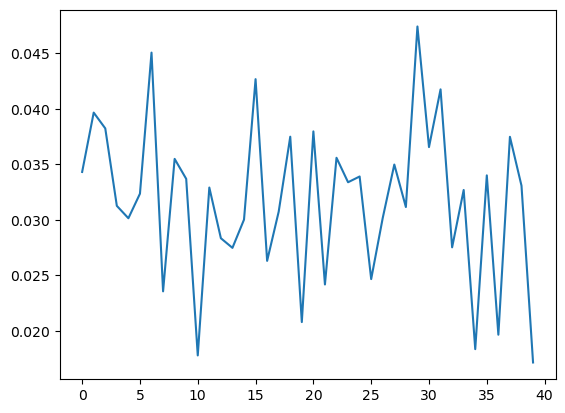

In [1534]:
gsq = torch.stack(course_list_914[1])
plt.plot(range(len(gsq)), gsq)

In [2280]:
course_list_914[0].keys()

dict_keys(['loss', 'loss_none', 'grad_sq'])

In [2274]:
r_list_list_914[1]['beta']

[tensor(6.),
 tensor(6.2653),
 tensor(7.3263),
 tensor(7.1226),
 tensor(7.5131),
 tensor(7.3464),
 tensor(7.4734),
 tensor(7.4905),
 tensor(7.6809),
 tensor(8.1867),
 tensor(8.0946),
 tensor(8.8237),
 tensor(9.2316),
 tensor(9.1879),
 tensor(9.4176),
 tensor(9.3522),
 tensor(9.5336),
 tensor(9.5197),
 tensor(9.7742),
 tensor(9.6803),
 tensor(9.7046),
 tensor(9.9644),
 tensor(10.2601),
 tensor(10.1246),
 tensor(9.9669),
 tensor(9.8650),
 tensor(9.5782),
 tensor(9.6681),
 tensor(9.6138),
 tensor(9.3384),
 tensor(9.0117),
 tensor(9.2467),
 tensor(9.1843),
 tensor(8.8622),
 tensor(8.8289),
 tensor(9.1534),
 tensor(8.8429),
 tensor(8.9066),
 tensor(8.7174),
 tensor(8.4700),
 tensor(8.2390)]

In [783]:
for param_name, param in r_list_list[0].items():
            setattr(agent, param_name, param[-1])

In [2290]:
for param_name, param in r_list_list_914[2].items():
    print(f'{param_name}: {param[20]}')

beta: 8.809211730957031
gamma: 3.246659517288208


In [ ]:
#mean f error in data for each condition
means = zeros(3)
count_f = zeros(3)
count_c = zeros(3)
m_f_error = zeros(3)
m_c_error = zeros(3)
count = 0
for b in torch.arange(nb):
    for t in torch.arange(nt):
        if questions[b, t] == 1:
            if ~torch.isnan(errors[b, t]):
                m_c_error[int(conditions[b])] += errors[b, t]
                count_c[int(conditions[b])] += 1
        elif questions[b, t] == 0:
            if ~torch.isnan(errors[b, t]):
                m_f_error[int(conditions[b])] += errors[b, t]
                count_f[int(conditions[b])] += 1
        count += 1

means = m_f_error / count_f 
print(means)
print(torch.sum(m_f_error) / torch.sum(count_f))

tensor([0.1606, 0.1262, 0.1166])
tensor(0.1344)


In [ ]:
#std f error in data for each condition
count_f = zeros(3)
count_c = zeros(3)
std_f_error = zeros(3)
std_c_error = zeros(3)
stds = zeros(3)
count = 0
for b in torch.arange(nb):
    for t in torch.arange(nt):
        if questions[b, t] == 1:
            if ~torch.isnan(errors[b, t]):
                std_c_error[int(conditions[b])] += (errors[b, t] - means[int(conditions[b])])**2
                count_c[int(conditions[b])] += 1
        elif questions[b, t] == 0:
            if ~torch.isnan(errors[b, t]):
                std_f_error[int(conditions[b])] += (errors[b, t] - means[int(conditions[b])])**2
                count_f[int(conditions[b])] += 1
        count += 1

stds = std_f_error / count_f 
print(stds)


tensor([0.0568, 0.0128, 0.0161])
